# Preparation

In [4]:
import pandas as pd
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import pingouin as pg
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import zscore
import numpy as np

In [5]:
# Base df
df = pd.read_csv('../data/z_df_ready_for_analysis.csv')

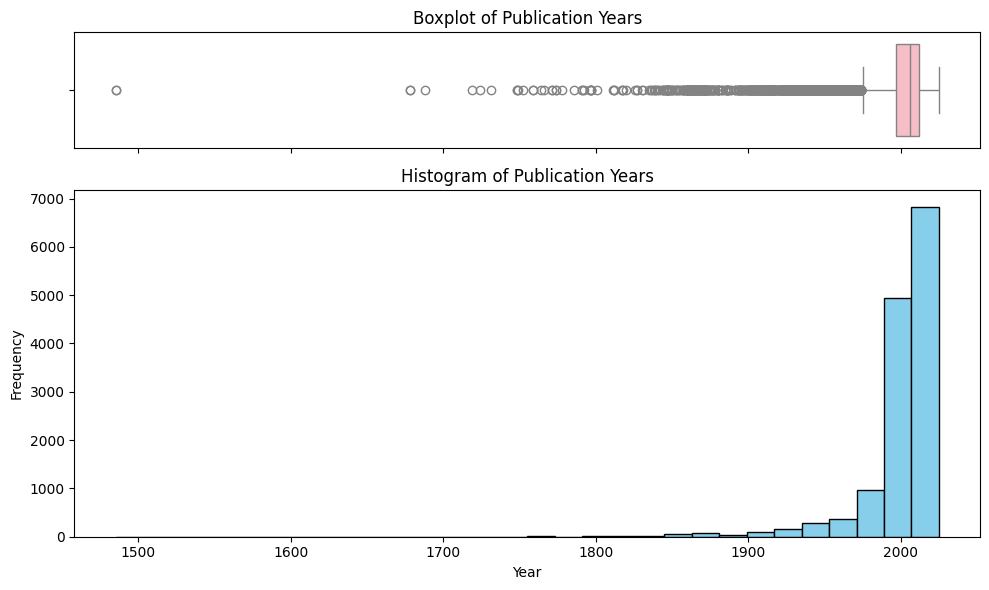

In [6]:
# Plot year outliers

fig, (ax_box, ax_hist) = plt.subplots(
    nrows=2, 
    sharex=True, 
    figsize=(10, 6), 
    gridspec_kw={"height_ratios": (1, 3)}
)

# Boxplot on top
sns.boxplot(x=df['year'], ax=ax_box, color='lightpink')
ax_box.set(title='Boxplot of Publication Years')
ax_box.set(xlabel='')

# Histogram below
ax_hist.hist(df['year'], bins=30, edgecolor='black', color='skyblue')
ax_hist.set(title='Histogram of Publication Years', xlabel='Year', ylabel='Frequency')

plt.tight_layout()
plt.show()

In [7]:
# df exluding year outliers

# Step 1: Compute Q1, Q3, and IQR
Q1 = df['year'].quantile(0.25)
Q3 = df['year'].quantile(0.75)
IQR = Q3 - Q1

# Step 2: Define outlier thresholds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Step 3: Filter the outlier rows
outlier_years = df[(df['year'] < lower_bound) | (df['year'] > upper_bound)]['year'].unique()

# Step 4: Keep only rows where 'year' is NOT an outlier
df_no_o = df[(df['year'] >= lower_bound) & (df['year'] <= upper_bound)].copy()

In [8]:
# Make sure gender is a categorical variable with the desired order for plotting
# Base df
df['author_gender'] = pd.Categorical(
    df['author_gender'].replace({0: 'Male', 1: 'Female'}),
    categories=['Male', 'Female'],
    ordered=True
)

# No outliers df
df_no_o['author_gender'] = pd.Categorical(
    df_no_o['author_gender'].replace({0: 'Male', 1: 'Female'}),
    categories=['Male', 'Female'],
    ordered=True
)

# Check Assumptions for MLR
## Linearity

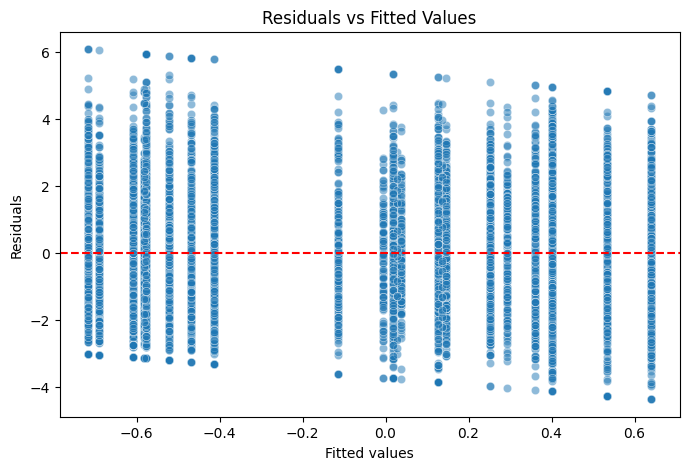

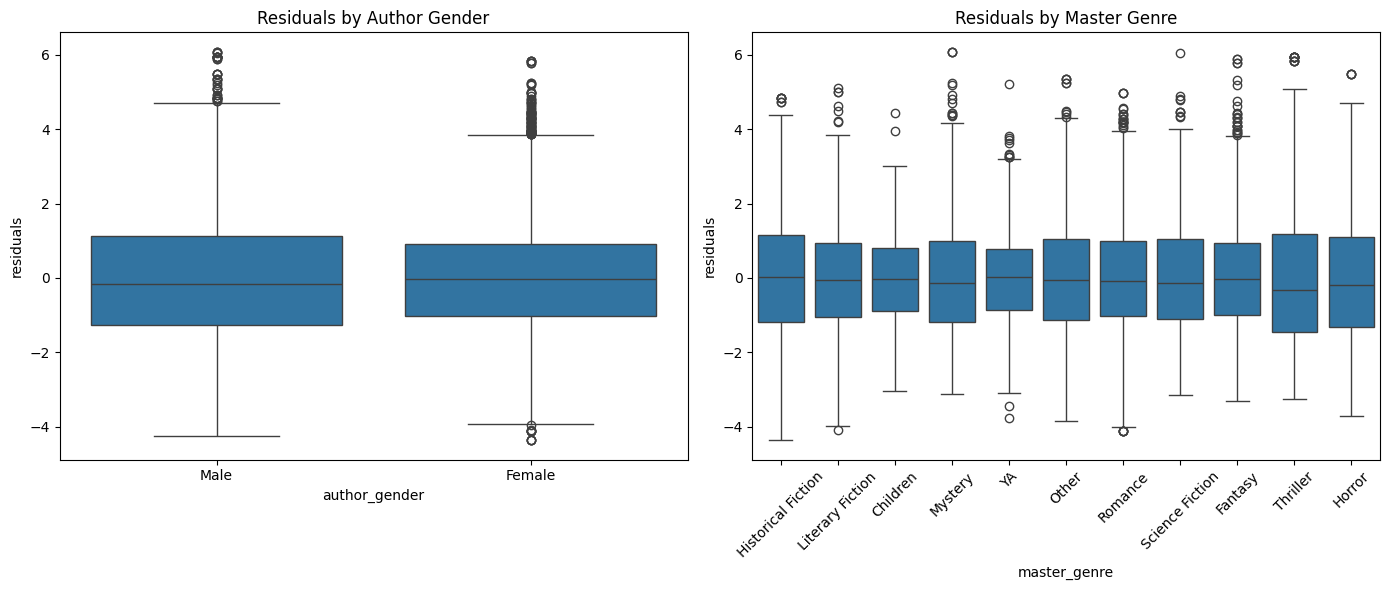

In [9]:
# Fit model
model = smf.ols('z_diff_prop ~ C(author_gender) + C(master_genre)', data=df).fit()

# Get residuals and fitted values
df['residuals'] = model.resid
df['fitted'] = model.fittedvalues

# 1. Residuals vs Fitted values plot (should be random scatter)
plt.figure(figsize=(8, 5))
sns.scatterplot(x='fitted', y='residuals', data=df, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.show()

# 2. Residuals by category plots

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x='author_gender', y='residuals', data=df)
plt.title('Residuals by Author Gender')

plt.subplot(1, 2, 2)
sns.boxplot(x='master_genre', y='residuals', data=df)
plt.title('Residuals by Master Genre')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


* Residuals vs Fitted plot: No pattern (no curve or funnel shape) means good linearity.
* Boxplots of residuals by category: Medians should be near zero and roughly similar spreads.

## Independence of errors

In [10]:
from statsmodels.stats.stattools import durbin_watson

dw_stat = durbin_watson(model.resid)
print(f'Durbin-Watson statistic: {dw_stat:.3f}')


Durbin-Watson statistic: 1.945


Around 2.0 → Residuals are independent (ideal)  
Closer to 0 → Positive autocorrelation (bad)  
Closer to 4 → Negative autocorrelation (also bad)  

## Homoscedasticity
* see Residuals vs. Fitted Values plot

## Multicollinearity

In [11]:
X = model.model.exog  # gets the design matrix
feature_names = model.model.exog_names

vif_data = pd.DataFrame()
vif_data["feature"] = feature_names
vif_data["VIF"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]

print(vif_data)


                                  feature        VIF
0                               Intercept  49.206397
1              C(author_gender)[T.Female]   1.164747
2              C(master_genre)[T.Fantasy]   6.843944
3   C(master_genre)[T.Historical Fiction]   5.049184
4               C(master_genre)[T.Horror]   2.098190
5     C(master_genre)[T.Literary Fiction]   5.087584
6              C(master_genre)[T.Mystery]   4.778303
7                C(master_genre)[T.Other]   4.423931
8              C(master_genre)[T.Romance]   8.688538
9      C(master_genre)[T.Science Fiction]   3.187410
10            C(master_genre)[T.Thriller]   3.848429
11                  C(master_genre)[T.YA]   4.073848


# Descriptives
## Standardized Means 
### General

In [12]:
df[['z_prop_pos','z_prop_neg','z_diff_prop']].describe()

,z_prop_pos,z_prop_neg,z_diff_prop
count,1.386900e+04,1.386900e+04,1.386900e+04
mean,1.352536e-16,-6.352823e-17,2.131270e-16
std,1.000036e+00,1.000036e+00,1.632462e+00
min,-1.733324e+00,-2.002652e+00,-3.726654e+00
25%,-7.145819e-01,-7.731193e-01,-1.150515e+00
50%,-3.542010e-02,-4.661141e-03,-3.407555e-02
75%,6.176201e-01,7.637970e-01,1.045082e+00
max,3.360389e+00,1.993330e+00,5.363041e+00


In [13]:
df_no_o[['z_prop_pos','z_prop_neg','z_diff_prop']].describe()

,z_prop_pos,z_prop_neg,z_diff_prop
count,12631.000000,12631.000000,12631.000000
mean,0.000967,0.043561,-0.042594
std,1.003642,1.001777,1.636969
min,-1.733324,-2.002652,-3.726654
25%,-0.714582,-0.773119,-1.183148
50%,-0.035420,0.149030,-0.092116
75%,0.617620,0.763797,0.998915
max,3.360389,1.993330,5.363041


### by Author Gender

In [14]:
df.groupby('author_gender')[['z_prop_pos','z_prop_neg','z_diff_prop']].describe()

/var/folders/g_/q_msxx211pb8_18_mgg8djyr0000gn/T/ipykernel_1965/1455878219.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('author_gender')[['z_prop_pos','z_prop_neg','z_diff_prop']].describe()


z_prop_pos                                                    \
                   count      mean       std       min       25%       50%   
author_gender                                                                
Male              4204.0 -0.136796  1.061596 -1.733324 -0.949676 -0.166028   
Female            9665.0  0.059502  0.966073 -1.733324 -0.557852 -0.035420   

                                 z_prop_neg            ...                     \
                   75%       max      count      mean  ...       75%      max   
author_gender                                          ...                      
Male           0.61762  3.360389     4204.0  0.057562  ...  0.994334  1.99333   
Female         0.61762  3.360389     9665.0 -0.025038  ...  0.661336  1.99333   

              z_diff_prop                                                    \
                    count      mean       std       min       25%       50%   
author_gender                                                                 
Male               4204.0 -0.194359  1.808203 -3.726654 -1.490531 -0.315059   
Female             9665.0  0.084540  1.542287 -3.726654 -0.989507  0.054758   

                                   
                    75%       max  
author_gender                      
Male           0.998915  5.363041  
Female         1.080116  5.363041  

[2 rows x 24 columns]

In [15]:
df_no_o.groupby('author_gender')[['z_prop_pos','z_prop_neg','z_diff_prop']].describe()

/var/folders/g_/q_msxx211pb8_18_mgg8djyr0000gn/T/ipykernel_1965/845911213.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_no_o.groupby('author_gender')[['z_prop_pos','z_prop_neg','z_diff_prop']].describe()


z_prop_pos                                                    \
                   count      mean       std       min       25%       50%   
author_gender                                                                
Male              3484.0 -0.173552  1.068145 -1.733324 -0.949676 -0.166028   
Female            9147.0  0.067439  0.969791 -1.733324 -0.557852 -0.035420   

                                 z_prop_neg            ...                     \
                   75%       max      count      mean  ...       75%      max   
author_gender                                          ...                      
Male           0.58200  3.360389     3484.0  0.170040  ...  1.071180  1.99333   
Female         0.61762  3.360389     9147.0 -0.004614  ...  0.763797  1.99333   

              z_diff_prop                                                    \
                    count      mean       std       min       25%       50%   
author_gender                                                                 
Male               3484.0 -0.343592  1.809531 -3.726654 -1.631071 -0.491834   
Female             9147.0  0.072053  1.551068 -3.726654 -1.014266  0.022705   

                                   
                    75%       max  
author_gender                      
Male           0.798446  5.363041  
Female         1.049726  5.363041  

[2 rows x 24 columns]

# Regressions

## Total (Difference in Standardized Proportions)
### Year Outliers Included

In [16]:
# Regression Coefficients 
model = smf.ols('z_diff_prop ~ author_gender + master_genre', data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            z_diff_prop   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     100.5
Date:                Wed, 23 Jul 2025   Prob (F-statistic):          3.94e-221
Time:                        18:04:43   Log-Likelihood:                -25944.
No. Observations:               13869   AIC:                         5.191e+04
Df Residuals:                   13857   BIC:                         5.200e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

In [17]:
# Regression Coefficients with interaction and year
model = smf.ols('z_diff_prop ~ author_gender + master_genre + author_gender*master_genre + year', data=df).fit()
print(model.summary())

# -> year significant (negative)

                            OLS Regression Results                            
Dep. Variable:            z_diff_prop   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     59.05
Date:                Wed, 23 Jul 2025   Prob (F-statistic):          3.49e-249
Time:                        18:04:43   Log-Likelihood:                -25854.
No. Observations:               13869   AIC:                         5.175e+04
Df Residuals:                   13846   BIC:                         5.193e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------

In [18]:
# ANOVA for easier reporting of categorical predictor results
# Without interaction -> ag and g significant
model_me = smf.ols('z_diff_prop ~ C(author_gender) + C(master_genre)', data=df).fit()
anova_model_me = anova_lm(model_me, typ=3)
print(anova_model_me)

                        sum_sq       df           F         PR(>F)
Intercept             0.232817      1.0    0.094256   7.588396e-01
C(author_gender)     29.322407      1.0   11.871137   5.717952e-04
C(master_genre)    2501.783718     10.0  101.284376  1.120967e-203
Residual          34227.605747  13857.0         NaN            NaN


In [19]:
# ANOVA for easier reporting of categorical predictor results
# Effect Sizes
anova = pg.anova(
    data=df,
    dv='z_diff_prop',
    between=['author_gender', 'master_genre'],
    detailed=True
)

print(anova)

# Effect size author gender: 0.000860 -> not even small
# Effect size genre: 0.068436 -> medium
# Effect size author gender*genre: 0.005042 -> small

                         Source            SS       DF          MS  \
0                 author_gender     29.322407      1.0   29.322407   
1                  master_genre   2501.783718     10.0  250.178372   
2  author_gender * master_genre    172.580206     10.0   17.258021   
3                      Residual  34055.025541  13847.0    2.459379   

            F          p-unc       np2  
0   11.922686   5.562023e-04  0.000860  
1  101.724191  1.485835e-204  0.068436  
2    7.017226   4.403798e-11  0.005042  
3         NaN            NaN       NaN  


In [20]:
# ANOVA for easier reporting of categorical predictor results
# With interaction -> ag*g significant
model_me_i = smf.ols('z_diff_prop ~ C(author_gender) * C(master_genre)', data=df).fit()
anova_model_me_i = anova_lm(model_me_i, typ=3)
print(anova_model_me_i)



                                        sum_sq       df          F  \
Intercept                             4.721091      1.0   1.919627   
C(author_gender)                     11.207324      1.0   4.556972   
C(master_genre)                    1012.999142     10.0  41.189219   
C(author_gender):C(master_genre)    172.580206     10.0   7.017226   
Residual                          34055.025541  13847.0        NaN   

                                        PR(>F)  
Intercept                         1.659201e-01  
C(author_gender)                  3.280249e-02  
C(master_genre)                   4.968027e-81  
C(author_gender):C(master_genre)  4.403798e-11  
Residual                                   NaN  


### Year Outliers NOT Included

In [21]:
# Regression Coefficients 
model = smf.ols('z_diff_prop ~ author_gender + master_genre + author_gender*master_genre + year', data=df_no_o).fit()
print(model.summary())

# -> year significant (negative) (but less)

                            OLS Regression Results                            
Dep. Variable:            z_diff_prop   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     53.49
Date:                Wed, 23 Jul 2025   Prob (F-statistic):          2.88e-224
Time:                        18:04:43   Log-Likelihood:                -23584.
No. Observations:               12631   AIC:                         4.721e+04
Df Residuals:                   12608   BIC:                         4.738e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------

In [22]:
# Without interaction -> ag and g still significant
model_me = smf.ols('z_diff_prop ~ C(author_gender) + C(master_genre)', data=df_no_o).fit()
anova_model_me = anova_lm(model_me, typ=3)
print(anova_model_me)

                        sum_sq       df          F         PR(>F)
Intercept            12.123820      1.0   4.900397   2.686833e-02
C(author_gender)     92.991200      1.0  37.586651   9.005012e-10
C(master_genre)    2188.287958     10.0  88.449678  2.855424e-177
Residual          31220.018489  12619.0        NaN            NaN


In [23]:
# ANOVA for easier reporting of categorical predictor results
# Effect Sizes
anova = pg.anova(
    data=df_no_o,
    dv='z_diff_prop',
    between=['author_gender', 'master_genre'],
    detailed=True
)

print(anova)

# Effect size author gender: 0.002987 -> not even small
# Effect size genre: 0.065851 -> medium
# Effect size author gender*genre: 0.005690 -> small
# Effect sizes are the same with and without outliers

                         Source            SS       DF          MS          F  \
0                 author_gender     92.991200      1.0   92.991200  37.771769   
1                  master_genre   2188.287958     10.0  218.828796  88.885300   
2  author_gender * master_genre    177.626852     10.0   17.762685   7.214963   
3                      Residual  31042.391637  12609.0    2.461923        NaN   

           p-unc       np2  
0   8.192248e-10  0.002987  
1  3.842548e-178  0.065851  
2   1.846697e-11  0.005690  
3            NaN       NaN  


In [24]:
# With interaction -> ag*g still significant
model_me_i = smf.ols('z_diff_prop ~ C(author_gender) * C(master_genre)', data=df_no_o).fit()
anova_model_me_i = anova_lm(model_me_i, typ=3)
print(anova_model_me_i)

                                        sum_sq       df          F  \
Intercept                             7.260051      1.0   2.948934   
C(author_gender)                      5.632129      1.0   2.287695   
C(master_genre)                     772.488173     10.0  31.377426   
C(author_gender):C(master_genre)    177.626852     10.0   7.214963   
Residual                          31042.391637  12609.0        NaN   

                                        PR(>F)  
Intercept                         8.595875e-02  
C(author_gender)                  1.304285e-01  
C(master_genre)                   1.174943e-60  
C(author_gender):C(master_genre)  1.846697e-11  
Residual                                   NaN  


### Plots (with outliers only)

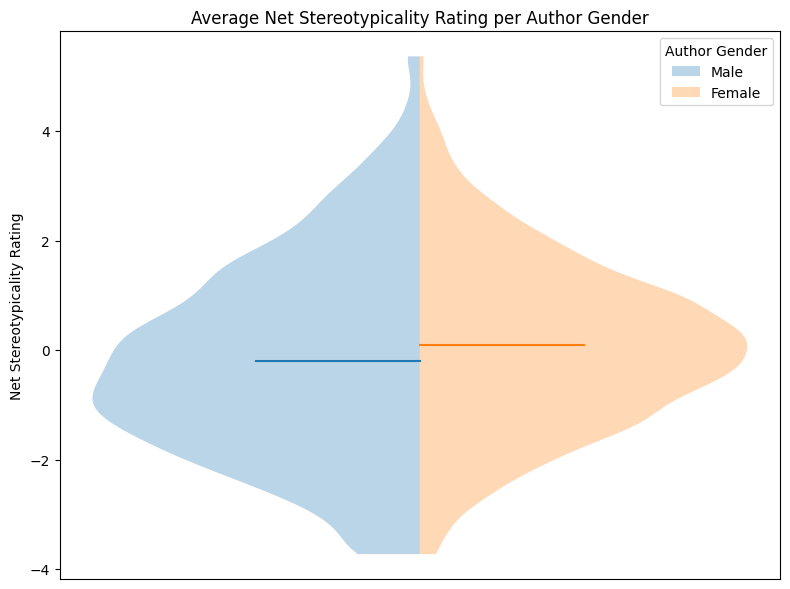

In [25]:
# Author Gender ME - Total - Plot
# Significance: C(author_gender)     29.322407      1.0   11.871137   5.717952e-04

# Extract groups
male_data = df[df['author_gender'] == 'Male']['z_diff_prop']
female_data = df[df['author_gender'] == 'Female']['z_diff_prop']

fig, ax = plt.subplots(figsize=(8, 6))

v1 = ax.violinplot(
    male_data,
    positions=[0],
    showmeans=True,
    showmedians=False,
    showextrema=False,
    side='low'
)

v2 = ax.violinplot(
    female_data,
    positions=[0],
    showmeans=True,
    showmedians=False,
    showextrema=False,
    side='high'
)

# Axis labels
ax.set_xticks([]) 
ax.set_xticklabels([])
ax.set_ylabel("Net Stereotypicality Rating")
ax.set_title("Average Net Stereotypicality Rating per Author Gender")

from matplotlib.patches import Patch

# Get actual colors from the violin objects
male_color = v1['bodies'][0].get_facecolor().flatten()
female_color = v2['bodies'][0].get_facecolor().flatten()

legend_elements = [
    Patch(facecolor=male_color, label='Male'),
    Patch(facecolor=female_color, label='Female')
]

ax.legend(handles=legend_elements, title='Author Gender')

plt.tight_layout()
plt.show()

In [26]:
# Author Gender ME - Total - Significance Test
tukey = pairwise_tukeyhsd(endog=df['z_diff_prop'],
                          groups=df['author_gender'],
                          alpha=0.05)
print(tukey)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper reject
-------------------------------------------------
Female   Male  -0.2789   0.0 -0.3378 -0.22   True
-------------------------------------------------


In [27]:
# Author Gender ME - Total - Effect size

# Subset the groups
group_male = df[df['author_gender'] == "Male"]['z_diff_prop']
group_female = df[df['author_gender'] == "Female"]['z_diff_prop']

# Calculate Cohen's d
d = pg.compute_effsize(group_female, group_male, eftype='cohen', paired=False)

print("Cohen's d:", d)


Cohen's d: 0.1713685941208073


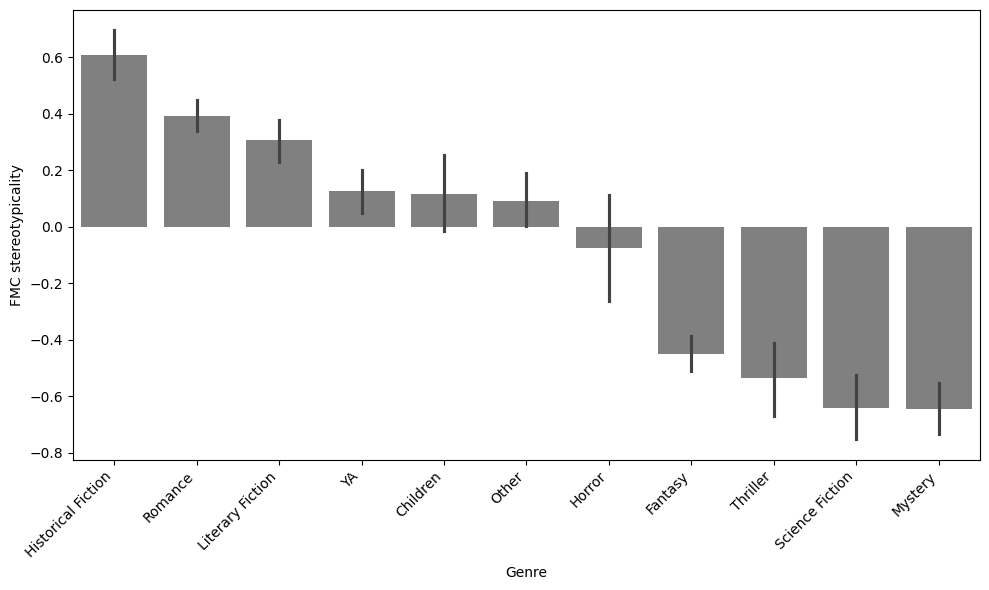

In [28]:
# Genre ME - Total - Plot
# Calculate means and confidence intervals per group
summary = df.groupby('master_genre')['z_diff_prop'].agg(['mean', 'count', 'std']).reset_index()
summary['sem'] = summary['std'] / summary['count']**0.5
summary['ci95'] = summary['sem'] * stats.t.ppf(0.975, df=summary['count']-1)  # 95% CI

# Sort genres by mean for consistent ordering
summary = summary.sort_values('mean', ascending=False)
order = summary['master_genre']

plt.figure(figsize=(10, 6))

# Plot bars with seaborn, ordered by 'order', using grayscale palette
barplot = sns.barplot(
    data=df, 
    x='master_genre', 
    y='z_diff_prop', 
    order=order, 
    errorbar=('ci', 95),
    color='gray'
)

# Map bar colors to genres
bar_colors = {}
for patch in barplot.patches:
    # x coordinate is the bar index
    x_pos = int(patch.get_x() + patch.get_width() / 2 + 0.001)  # tiny offset to avoid float issues
    bar_colors[order.iloc[x_pos]] = patch.get_facecolor()

# Draw horizontal mean lines and two dashed lines for CI bounds
for _, row in summary.iterrows():
    genre = row['master_genre']
    mean = row['mean']
    ci = row['ci95']
    color = bar_colors[genre]
    
    # # Lower CI bound dashed line
    # plt.hlines(y=mean - ci, xmin=-0.5, xmax=len(summary)-0.5, colors=color, linestyles='dashed', linewidth=2)
    
    # # Upper CI bound dashed line
    # plt.hlines(y=mean + ci, xmin=-0.5, xmax=len(summary)-0.5, colors=color, linestyles='dashed', linewidth=2)

plt.xticks(ticks=range(len(summary)), labels=order, rotation=45, ha='right')
plt.ylabel("FMC stereotypicality")
plt.xlabel("Genre")
plt.tight_layout()
plt.savefig('../visualizations/Figure 3.png', dpi=300)
plt.show()

In [29]:
# ONLINE SUPPLEMENT ONLY
# Genre ME - Total - Significance Test 

# -- Which genres are significantly different from each other? --

# Drop NA values to avoid errors
df_clean = df[['master_genre', 'z_diff_prop']].dropna()

# Perform Tukey HSD
tukey = pairwise_tukeyhsd(endog=df_clean['z_diff_prop'],
                          groups=df_clean['master_genre'],
                          alpha=0.05)

print(tukey.summary())

# Convert Tukey results to a DataFrame
tukey_results = pd.DataFrame(
    data=tukey._results_table.data[1:],  # Skip header
    columns=tukey._results_table.data[0]  # Column names
)

tukey_results.to_latex('tukey_results.tex', index=False)

            Multiple Comparison of Means - Tukey HSD, FWER=0.05             
      group1             group2       meandiff p-adj   lower   upper  reject
----------------------------------------------------------------------------
          Children            Fantasy  -0.5666    0.0 -0.8762  -0.257   True
          Children Historical Fiction   0.4905    0.0  0.1708  0.8102   True
          Children             Horror  -0.1931 0.8992 -0.5917  0.2056  False
          Children   Literary Fiction   0.1906  0.705 -0.1291  0.5102  False
          Children            Mystery  -0.7613    0.0 -1.0833 -0.4393   True
          Children              Other  -0.0261    1.0 -0.3516  0.2995  False
          Children            Romance   0.2759 0.1154 -0.0278  0.5796  False
          Children    Science Fiction  -0.7588    0.0 -1.1054 -0.4121   True
          Children           Thriller  -0.6535    0.0 -0.9875 -0.3196   True
          Children                 YA   0.0111    1.0 -0.3186  0.3407  False

In [30]:
order = df_no_o.groupby('master_genre')['z_diff_prop'].mean().sort_values(ascending=False).index

#significance test within genres
for genre in order:
    print(f"Genre: {genre}")
    genre_data = df_no_o[df_no_o['master_genre'] == genre]
    
    # Perform Tukey HSD
    tukey = pairwise_tukeyhsd(endog=genre_data['z_diff_prop'],
                              groups=genre_data['author_gender'],
                              alpha=0.05)
    print(tukey)


plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=df_no_o,
    x='master_genre',
    y='z_diff_prop',
    hue='author_gender',
    palette=gray_colors,
    errorbar=('ci', 95),
    order=order
)
plt.xticks(rotation=45, ha='right')
plt.ylabel("FMC stereotypicality")
plt.xlabel("Genre")
plt.legend(title="Author Gender")
plt.tight_layout()


# Add significance stars for gender difference within each genre
for i, genre in enumerate(order):
    genre_data = df_no_o[df_no_o['master_genre'] == genre]
    tukey = pairwise_tukeyhsd(endog=genre_data['z_diff_prop'],
                              groups=genre_data['author_gender'],
                              alpha=0.05)
    # Get p-value for Male vs Female
    try:
        pval = tukey.pvalues[0]
    except Exception:
        pval = np.nan
    # Determine number of stars
    if pval < 0.001:
        stars = '***'
    elif pval < 0.01:
        stars = '**'
    elif pval < 0.05:
        stars = '*'
    else:
        stars = ''
    # Get bar heights for annotation
    means = genre_data.groupby('author_gender')['z_diff_prop'].mean()
    y_max = means.max()
    # Annotate above the bars
    ax.text(i, y_max + 0.15, stars, ha='center', va='bottom', fontsize=16, color='black')
plt.savefig('../visualizations/Figure 4.png', dpi=300)
plt.show()



Genre: Historical Fiction
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
Female   Male  -0.1805 0.0963 -0.3933 0.0323  False
---------------------------------------------------
Genre: Romance
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
Female   Male  -0.0146 0.9073 -0.2595 0.2304  False
---------------------------------------------------
Genre: Literary Fiction
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
Female   Male     -0.1 0.2844 -0.2831 0.0832  False
---------------------------------------------------
Genre: YA
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
-----------------------------------------

NameError: name 'gray_colors' is not defined

<Figure size 1200x600 with 0 Axes>

In [ ]:
# ONLINE SUPPLEMENT ONLY
# Interaction - Total - Significance Test

df_clean = df[['master_genre', 'author_gender', 'z_diff_prop']].dropna()

# Create interaction column
df_clean['interaction'] = df_clean['author_gender'].astype(str) + "_" + df_clean['master_genre'].astype(str)

# Run Tukey's HSD
tukey = pairwise_tukeyhsd(endog=df_clean['z_diff_prop'],
                          groups=df_clean['interaction'],
                          alpha=0.05)

print(tukey.summary())

# Convert Tukey results to a DataFrame
tukey_results = pd.DataFrame(
    data=tukey._results_table.data[1:],  # Skip header
    columns=tukey._results_table.data[0]  # Column names
)
tukey_results.to_latex('tukey_results.tex', index=False)

                   Multiple Comparison of Means - Tukey HSD, FWER=0.05                    
          group1                    group2          meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------------------------
          Female_Children            Female_Fantasy  -0.5565    0.0 -0.9417 -0.1713   True
          Female_Children Female_Historical Fiction   0.3981 0.0509 -0.0006  0.7968  False
          Female_Children             Female_Horror  -0.3642   0.89  -0.988  0.2595  False
          Female_Children   Female_Literary Fiction   0.1068    1.0 -0.3048  0.5183  False
          Female_Children            Female_Mystery  -0.9715    0.0 -1.3744 -0.5686   True
          Female_Children              Female_Other  -0.0078    1.0 -0.4163  0.4006  False
          Female_Children            Female_Romance   0.1816 0.9808 -0.1892  0.5525  False
          Female_Children    Female_Science Fiction  -0.5039 0.0227 -0.9778 -0.0301   True

In [ ]:
# Author Gender * Genre - Total - Effect size - Fantasy

# Subset the groups
group_female_fantasy = df[(df['author_gender'] == "Female") & (df['master_genre'] == "Fantasy")]['z_diff_prop']
group_male_fantasy = df[(df['author_gender'] == "Male") & (df['master_genre'] == "Fantasy")]['z_diff_prop']

# Calculate Cohen's d
d = pg.compute_effsize(group_female_fantasy, group_male_fantasy, eftype='cohen', paired=False)

print("Cohen's d for Female vs Male Fantasy:", d)

Cohen's d for Female vs Male Fantasy: 0.20428068176176006


In [ ]:
# Author Gender * Genre - Total - Effect size - Science Fiction

# Subset the groups
group_female_scifi = df[(df['author_gender'] == "Female") & (df['master_genre'] == "Science Fiction")]['z_diff_prop']
group_male_scifi = df[(df['author_gender'] == "Male") & (df['master_genre'] == "Science Fiction")]['z_diff_prop']

# Calculate Cohen's d
d = pg.compute_effsize(group_female_scifi, group_male_scifi, eftype='cohen', paired=False)

print("Cohen's d for Female vs Male Science Fiction:", d)

Cohen's d for Female vs Male Science Fiction: 0.39596323341354894


In [ ]:
# Author Gender * Genre - Total - Effect size - Mystery

# Subset the groups
group_female_mystery = df[(df['author_gender'] == "Female") & (df['master_genre'] == "Mystery")]['z_diff_prop']
group_male_mystery = df[(df['author_gender'] == "Male") & (df['master_genre'] == "Mystery")]['z_diff_prop']

# Calculate Cohen's d
d = pg.compute_effsize(group_female_mystery, group_male_mystery, eftype='cohen', paired=False)

print("Cohen's d for Female vs Male Mystery:", d)

Cohen's d for Female vs Male Mystery: -0.23209287357454234


## Standardized Pro-Stereotypical Items
### Year Outliers Included

In [ ]:
# Regression Coefficients 
model = smf.ols('z_prop_pos ~ author_gender + master_genre + author_gender*master_genre + year', data=df).fit()
print(model.summary())

# -> year significant (negative)

                            OLS Regression Results                            
Dep. Variable:             z_prop_pos   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     38.37
Date:                Mon, 21 Jul 2025   Prob (F-statistic):          3.31e-159
Time:                        14:57:03   Log-Likelihood:                -19269.
No. Observations:               13869   AIC:                         3.858e+04
Df Residuals:                   13846   BIC:                         3.876e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------

In [ ]:
# Without interaction -> ag and g significant
model_me = smf.ols('z_prop_pos ~ C(author_gender) + C(master_genre)', data=df).fit()
anova_model_me = anova_lm(model_me, typ=3)
print(anova_model_me)

                        sum_sq       df          F         PR(>F)
Intercept            74.849729      1.0  78.576149   8.624914e-19
C(author_gender)     45.844220      1.0  48.126590   4.172978e-12
C(master_genre)     556.268960     10.0  58.396300  1.619220e-116
Residual          13199.841379  13857.0        NaN            NaN


In [ ]:
# ANOVA for easier reporting of categorical predictor results
# Effect Sizes
anova = pg.anova(
    data=df,
    dv='z_prop_pos',
    between=['author_gender', 'master_genre'],
    detailed=True
)

print(anova)

# Effect size author gender: 0.003483 -> very small
# Effect size genre: 0.040682 -> small
# Effect size author gender*genre: 0.006240 -> very small

                         Source            SS       DF         MS          F  \
0                 author_gender     45.844220      1.0  45.844220  48.393839   
1                  master_genre    556.268960     10.0  55.626896  58.720577   
2  author_gender * master_genre     82.367637     10.0   8.236764   8.694850   
3                      Residual  13117.473742  13847.0   0.947315        NaN   

           p-unc       np2  
0   3.643140e-12  0.003483  
1  3.505015e-117  0.040682  
2   2.408406e-14  0.006240  
3            NaN       NaN  


In [ ]:
# With interaction -> ag*g significant
model_me_i = smf.ols('z_prop_pos ~ C(author_gender) * C(master_genre)', data=df).fit()
anova_model_me_i = anova_lm(model_me_i, typ=3)
print(anova_model_me_i)

                                        sum_sq       df          F  \
Intercept                            22.901505      1.0  24.175169   
C(author_gender)                      4.003445      1.0   4.226096   
C(master_genre)                     141.281194     10.0  14.913853   
C(author_gender):C(master_genre)     82.367637     10.0   8.694850   
Residual                          13117.473742  13847.0        NaN   

                                        PR(>F)  
Intercept                         8.896740e-07  
C(author_gender)                  3.982561e-02  
C(master_genre)                   8.012838e-27  
C(author_gender):C(master_genre)  2.408406e-14  
Residual                                   NaN  


### Year Outliers NOT Included

In [ ]:
# Regression Coefficients 
model = smf.ols('z_prop_pos ~ author_gender + master_genre + author_gender*master_genre + year', data=df_no_o).fit()
print(model.summary())

# -> year significant (negative) (but stronger)

                            OLS Regression Results                            
Dep. Variable:             z_prop_pos   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     35.34
Date:                Mon, 21 Jul 2025   Prob (F-statistic):          1.90e-145
Time:                        14:57:12   Log-Likelihood:                -17590.
No. Observations:               12631   AIC:                         3.523e+04
Df Residuals:                   12608   BIC:                         3.540e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------

In [ ]:
# Without interaction -> ag and g still significant
model_me = smf.ols('z_prop_pos ~ C(author_gender) + C(master_genre)', data=df_no_o).fit()
anova_model_me = anova_lm(model_me, typ=3)
print(anova_model_me)

                        sum_sq       df          F         PR(>F)
Intercept            85.613578      1.0  89.407717   3.774549e-21
C(author_gender)     64.582396      1.0  67.444495   2.376910e-16
C(master_genre)     492.143316     10.0  51.395364  6.407905e-102
Residual          12083.495542  12619.0        NaN            NaN


In [ ]:
# With interaction -> ag*g still significant
model_me_i = smf.ols('z_prop_pos ~ C(author_gender) * C(master_genre)', data=df_no_o).fit()
anova_model_me_i = anova_lm(model_me_i, typ=3)
print(anova_model_me_i)

                                        sum_sq       df          F  \
Intercept                            22.385091      1.0  23.527710   
C(author_gender)                      1.802653      1.0   1.894668   
C(master_genre)                     108.412904     10.0  11.394671   
C(author_gender):C(master_genre)     86.849580     10.0   9.128271   
Residual                          11996.645962  12609.0        NaN   

                                        PR(>F)  
Intercept                         1.245990e-06  
C(author_gender)                  1.687009e-01  
C(master_genre)                   1.062845e-19  
C(author_gender):C(master_genre)  3.418789e-15  
Residual                                   NaN  


### Plots (all with outliers)

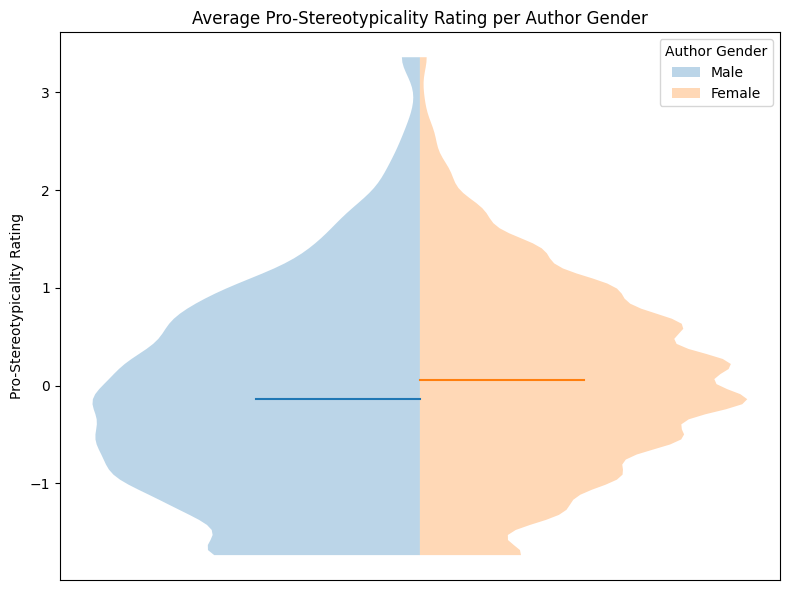

In [ ]:
# Author Gender ME - Pos - Plot
# Significance: C(author_gender)     45.844220      1.0  48.126590   4.172978e-12

# Extract groups
male_data = df[df['author_gender'] == 'Male']['z_prop_pos']
female_data = df[df['author_gender'] == 'Female']['z_prop_pos']

fig, ax = plt.subplots(figsize=(8, 6))

v1 = ax.violinplot(
    male_data,
    positions=[0],
    showmeans=True,
    showmedians=False,
    showextrema=False,
    side='low'
)

v2 = ax.violinplot(
    female_data,
    positions=[0],
    showmeans=True,
    showmedians=False,
    showextrema=False,
    side='high'
)

# Axis labels
ax.set_xticks([]) 
ax.set_xticklabels([])
ax.set_ylabel("Pro-Stereotypicality Rating")
ax.set_title("Average Pro-Stereotypicality Rating per Author Gender")

from matplotlib.patches import Patch

# Get actual colors from the violin objects
male_color = v1['bodies'][0].get_facecolor().flatten()
female_color = v2['bodies'][0].get_facecolor().flatten()

legend_elements = [
    Patch(facecolor=male_color, label='Male'),
    Patch(facecolor=female_color, label='Female')
]

ax.legend(handles=legend_elements, title='Author Gender')

plt.tight_layout()
plt.show()

In [ ]:
# Author Gender ME - Pro - Significance Test
tukey = pairwise_tukeyhsd(endog=df['z_prop_pos'],
                          groups=df['author_gender'],
                          alpha=0.05)
print(tukey)

# Author Gender ME - Pro - Effect size

# Subset the groups
group_male = df[df['author_gender'] == "Male"]['z_prop_pos']
group_female = df[df['author_gender'] == "Female"]['z_prop_pos']

# Calculate Cohen's d
d = pg.compute_effsize(group_female, group_male, eftype='cohen', paired=False)

print("Cohen's d:", d)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
Female   Male  -0.1963   0.0 -0.2324 -0.1602   True
---------------------------------------------------
Cohen's d: 0.19708828394831462


/var/folders/g_/q_msxx211pb8_18_mgg8djyr0000gn/T/ipykernel_2917/2552036923.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(data=df,


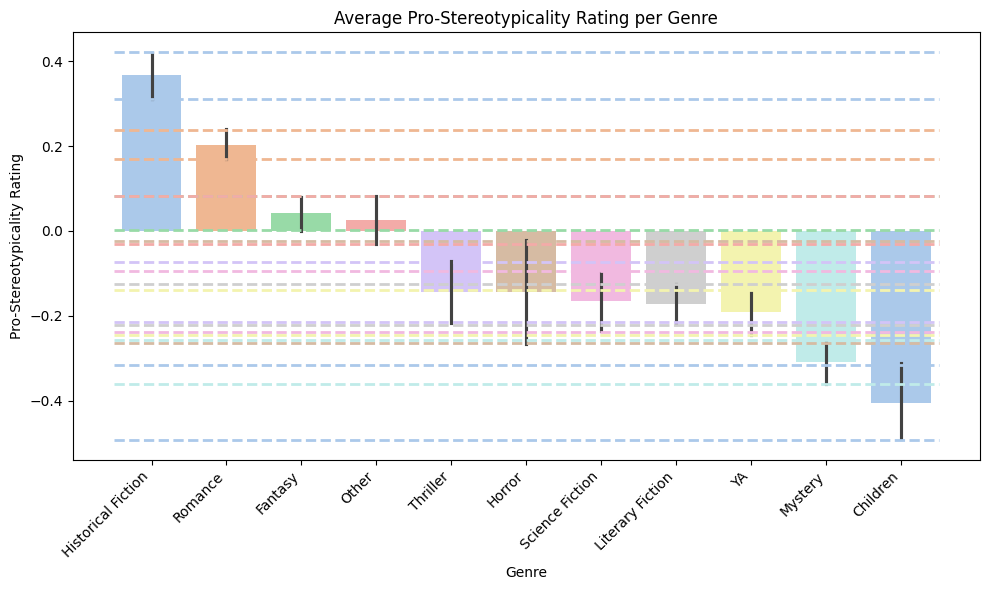

In [ ]:
# Genre ME - Pos - Plot

# Calculate means and confidence intervals per group
summary = df.groupby('master_genre')['z_prop_pos'].agg(['mean', 'count', 'std']).reset_index()
summary['sem'] = summary['std'] / summary['count']**0.5
summary['ci95'] = summary['sem'] * stats.t.ppf(0.975, df=summary['count']-1)  # 95% CI

# Sort genres by mean for consistent ordering
summary = summary.sort_values('mean', ascending=False)
order = summary['master_genre']

plt.figure(figsize=(10, 6))

# Plot bars with seaborn, ordered by 'order'
barplot = sns.barplot(data=df, 
                      x='master_genre', 
                      y='z_prop_pos', 
                      order=order, 
                      palette='pastel', 
                      errorbar=('ci', 95))

# Map bar colors to genres
bar_colors = {}
for patch in barplot.patches:
    # x coordinate is the bar index
    x_pos = int(patch.get_x() + patch.get_width() / 2 + 0.001)  # tiny offset to avoid float issues
    bar_colors[order.iloc[x_pos]] = patch.get_facecolor()

# Draw horizontal mean lines and two dashed lines for CI bounds
for _, row in summary.iterrows():
    genre = row['master_genre']
    mean = row['mean']
    ci = row['ci95']
    color = bar_colors[genre]
    
    # Lower CI bound dashed line
    plt.hlines(y=mean - ci, xmin=-0.5, xmax=len(summary)-0.5, colors=color, linestyles='dashed', linewidth=2)
    
    # Upper CI bound dashed line
    plt.hlines(y=mean + ci, xmin=-0.5, xmax=len(summary)-0.5, colors=color, linestyles='dashed', linewidth=2)

plt.title("Average Pro-Stereotypicality Rating per Genre")
plt.xticks(ticks=range(len(summary)), labels=order, rotation=45, ha='right')
plt.ylabel("Pro-Stereotypicality Rating")
plt.xlabel("Genre")
plt.tight_layout()
plt.show()

In [ ]:
# ONLINE SUPPLEMENT ONLY
# Genre ME - Pos - Significance Test 

# -- Which genres are significantly different from each other? --

# Drop NA values to avoid errors
df_clean = df[['master_genre', 'z_prop_pos']].dropna()

# Perform Tukey HSD
tukey = pairwise_tukeyhsd(endog=df_clean['z_prop_pos'],
                          groups=df_clean['master_genre'],
                          alpha=0.05)

print(tukey.summary())

            Multiple Comparison of Means - Tukey HSD, FWER=0.05             
      group1             group2       meandiff p-adj   lower   upper  reject
----------------------------------------------------------------------------
          Children            Fantasy   0.4464    0.0  0.2538  0.6389   True
          Children Historical Fiction   0.7711    0.0  0.5723  0.9699   True
          Children             Horror   0.2603 0.0301  0.0124  0.5081   True
          Children   Literary Fiction   0.2311 0.0084  0.0323  0.4299   True
          Children            Mystery   0.0945 0.9137 -0.1057  0.2947  False
          Children              Other   0.4306    0.0  0.2282   0.633   True
          Children            Romance   0.6077    0.0  0.4189  0.7966   True
          Children    Science Fiction   0.2381 0.0166  0.0225  0.4536   True
          Children           Thriller   0.2605 0.0027  0.0528  0.4681   True
          Children                 YA   0.2122 0.0351  0.0072  0.4172   True

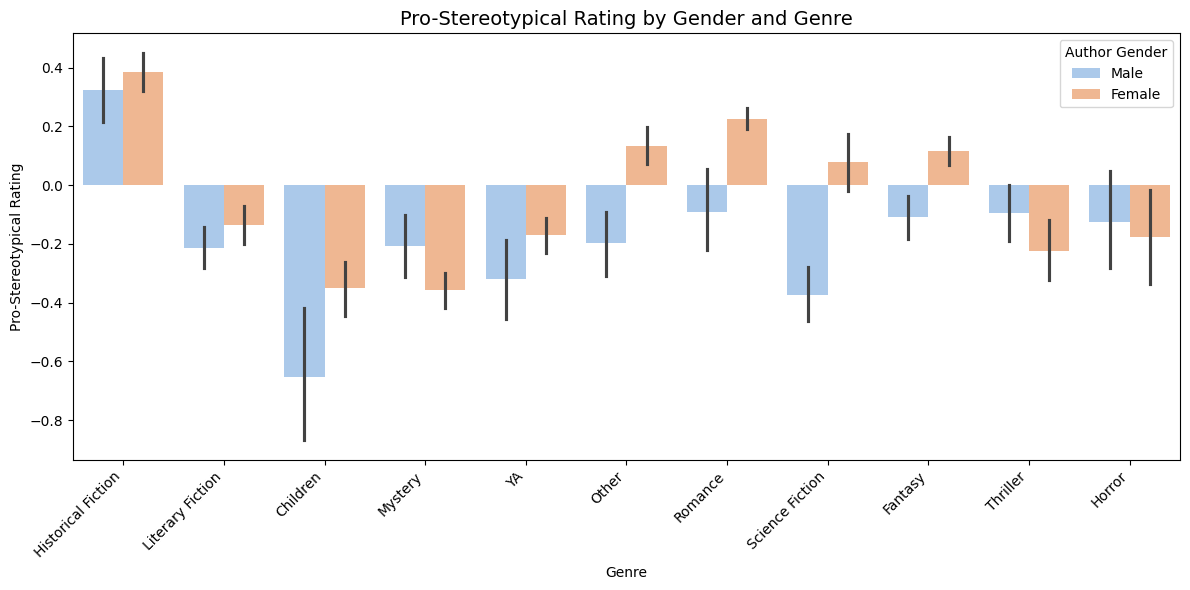

In [ ]:
# Interaction - Pos - Plot

plt.figure(figsize=(12, 6))

sns.barplot(
    data=df,
    x='master_genre',
    y='z_prop_pos',
    hue='author_gender',
    palette='pastel',
    errorbar=('ci', 95),
)

plt.xticks(rotation=45, ha='right')
plt.title("Pro-Stereotypical Rating by Gender and Genre", fontsize=14)
plt.ylabel("Pro-Stereotypical Rating")
plt.xlabel("Genre")
plt.legend(title="Author Gender")
plt.tight_layout()
plt.show()

In [ ]:
# ONLINE SUPPLEMENT ONLY
# Interaction - Pos - Significance Test

df_clean = df[['master_genre', 'author_gender', 'z_prop_pos']].dropna()

# Create interaction column
df_clean['interaction'] = df_clean['author_gender'].astype(str) + "_" + df_clean['master_genre'].astype(str)

# Run Tukey's HSD
tukey = pairwise_tukeyhsd(endog=df_clean['z_prop_pos'],
                          groups=df_clean['interaction'],
                          alpha=0.05)

print(tukey.summary())

/Users/hannes/Documents/svenjas paper/.venv/lib/python3.13/site-packages/scipy/integrate/_quadpack_py.py:1264: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


                   Multiple Comparison of Means - Tukey HSD, FWER=0.05                    
          group1                    group2          meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------------------------
          Female_Children            Female_Fantasy   0.4665    0.0  0.2274  0.7055   True
          Female_Children Female_Historical Fiction   0.7366    0.0  0.4892  0.9841   True
          Female_Children             Female_Horror   0.1744 0.9929 -0.2127  0.5615  False
          Female_Children   Female_Literary Fiction   0.2157 0.2427 -0.0397  0.4711  False
          Female_Children            Female_Mystery  -0.0064    1.0 -0.2565  0.2436  False
          Female_Children              Female_Other   0.4846    0.0  0.2311  0.7381   True
          Female_Children            Female_Romance   0.5764    0.0  0.3462  0.8065   True
          Female_Children    Female_Science Fiction   0.4298    0.0  0.1357  0.7239   True

In [ ]:
# Author Gender*Genre - Pro - Effect size - Fantasy

# Subset the groups
group_female_fantasy = df[(df['author_gender'] == "Female") & (df['master_genre'] == "Fantasy")]['z_prop_pos']
group_male_fantasy = df[(df['author_gender'] == "Male") & (df['master_genre'] == "Fantasy")]['z_prop_pos']

# Calculate Cohen's d
d = pg.compute_effsize(group_female_fantasy, group_male_fantasy, eftype='cohen', paired=False)

print("Cohen's d:", d)

Cohen's d: 0.23559718335217955


In [ ]:
# Author Gender*Genre - Pro - Effect size - Other

# Subset the groups
group_female_other = df[(df['author_gender'] == "Female") & (df['master_genre'] == "Other")]['z_prop_pos']
group_male_other = df[(df['author_gender'] == "Male") & (df['master_genre'] == "Other")]['z_prop_pos']

# Calculate Cohen's d
d = pg.compute_effsize(group_female_other, group_male_other, eftype='cohen', paired=False)

print("Cohen's d:", d)

Cohen's d: 0.3374209544545705


In [ ]:
# Author Gender*Genre - Pro - Effect size - Romance

# Subset the groups
group_female_romance = df[(df['author_gender'] == "Female") & (df['master_genre'] == "Romance")]['z_prop_pos']
group_male_romance = df[(df['author_gender'] == "Male") & (df['master_genre'] == "Romance")]['z_prop_pos']

# Calculate Cohen's d
d = pg.compute_effsize(group_female_romance, group_male_romance, eftype='cohen', paired=False)

print("Cohen's d:", d)

Cohen's d: 0.32399947862856493


In [ ]:
# Author Gender*Genre - Pro - Effect size - Sci-Fi

# Subset the groups
group_female_scifi = df[(df['author_gender'] == "Female") & (df['master_genre'] == "Science Fiction")]['z_prop_pos']
group_male_scifi = df[(df['author_gender'] == "Male") & (df['master_genre'] == "Science Fiction")]['z_prop_pos']

# Calculate Cohen's d
d = pg.compute_effsize(group_female_scifi, group_male_scifi, eftype='cohen', paired=False)

print("Cohen's d:", d)

Cohen's d: 0.48036810835699184


## Standardized Anti-Stereotypical Items
### Year Outliers Included

In [ ]:
# Regression Coefficients 
model = smf.ols('z_prop_neg ~ author_gender + master_genre + author_gender*master_genre + year', data=df).fit()
print(model.summary())

# -> year significant (pos)

                            OLS Regression Results                            
Dep. Variable:             z_prop_neg   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     97.03
Date:                Mon, 21 Jul 2025   Prob (F-statistic):               0.00
Time:                        14:57:59   Log-Likelihood:                -18685.
No. Observations:               13869   AIC:                         3.742e+04
Df Residuals:                   13846   BIC:                         3.759e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------

In [ ]:
# Without interaction -> ag not significant, g significant
model_me = smf.ols('z_prop_neg ~ C(author_gender) + C(master_genre)', data=df).fit()
anova_model_me = anova_lm(model_me, typ=3)
print(anova_model_me)

                        sum_sq       df           F        PR(>F)
Intercept            83.431512      1.0   94.906435  2.354448e-22
C(author_gender)      1.838246      1.0    2.091072  1.481846e-01
C(master_genre)    1667.430027     10.0  189.676341  0.000000e+00
Residual          12181.581389  13857.0         NaN           NaN


In [ ]:
# ANOVA for easier reporting of categorical predictor results
# Effect Sizes
anova = pg.anova(
    data=df,
    dv='z_prop_neg',
    between=['author_gender', 'master_genre'],
    detailed=True
)

print(anova)

# Effect size author gender: 0.000152
# Effect size genre: 0.121033
# Effect size author gender*genre: 0.005943

                         Source            SS       DF          MS  \
0                 author_gender      1.838246      1.0    1.838246   
1                  master_genre   1667.430027     10.0  166.743003   
2  author_gender * master_genre     72.397853     10.0    7.239785   
3                      Residual  12109.183535  13847.0    0.874499   

            F         p-unc       np2  
0    2.102056  1.471238e-01  0.000152  
1  190.672670  0.000000e+00  0.121033  
2    8.278783  1.574489e-13  0.005943  
3         NaN           NaN       NaN  


In [ ]:
# With interaction -> ag*g significant
model_me_i = smf.ols('z_prop_neg ~ C(author_gender) * C(master_genre)', data=df).fit()
anova_model_me_i = anova_lm(model_me_i, typ=3)
print(anova_model_me_i)

                                        sum_sq       df          F  \
Intercept                             6.826434      1.0   7.806111   
C(author_gender)                      1.814067      1.0   2.074408   
C(master_genre)                     777.140739     10.0  88.866997   
C(author_gender):C(master_genre)     72.397853     10.0   8.278783   
Residual                          12109.183535  13847.0        NaN   

                                         PR(>F)  
Intercept                          5.214140e-03  
C(author_gender)                   1.498107e-01  
C(master_genre)                   1.186714e-178  
C(author_gender):C(master_genre)   1.574489e-13  
Residual                                    NaN  


### Year Outliers NOT Included

In [ ]:
# Regression Coefficients 
model = smf.ols('z_prop_neg ~ author_gender + master_genre + author_gender*master_genre + year', data=df_no_o).fit()
print(model.summary())

# -> year significant (positive) (but more)

                            OLS Regression Results                            
Dep. Variable:             z_prop_neg   R-squared:                       0.133
Model:                            OLS   Adj. R-squared:                  0.131
Method:                 Least Squares   F-statistic:                     87.63
Date:                Mon, 21 Jul 2025   Prob (F-statistic):               0.00
Time:                        14:58:08   Log-Likelihood:                -17046.
No. Observations:               12631   AIC:                         3.414e+04
Df Residuals:                   12608   BIC:                         3.431e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------

In [ ]:
# Without interaction -> ag still not significant, g still significant
model_me = smf.ols('z_prop_neg ~ C(author_gender) + C(master_genre)', data=df_no_o).fit()
anova_model_me = anova_lm(model_me, typ=3)
print(anova_model_me)

                        sum_sq       df           F        PR(>F)
Intercept            33.302512      1.0   37.856057  7.846658e-10
C(author_gender)      2.582054      1.0    2.935106  8.669756e-02
C(master_genre)    1496.860109     10.0  170.152994  0.000000e+00
Residual          11101.113900  12619.0         NaN           NaN


In [ ]:
# With interaction -> ag*g still significant
model_me_i = smf.ols('z_prop_neg ~ C(author_gender) * C(master_genre)', data=df_no_o).fit()
anova_model_me_i = anova_lm(model_me_i, typ=3)
print(anova_model_me_i)

                                        sum_sq       df          F  \
Intercept                             4.148719      1.0   4.744191   
C(author_gender)                      1.062098      1.0   1.214543   
C(master_genre)                     653.503311     10.0  74.730171   
C(author_gender):C(master_genre)     74.746444     10.0   8.547492   
Residual                          11026.367456  12609.0        NaN   

                                         PR(>F)  
Intercept                          2.941584e-02  
C(author_gender)                   2.704553e-01  
C(master_genre)                   1.470026e-149  
C(author_gender):C(master_genre)   4.737335e-14  
Residual                                    NaN  


### Plots (all with outliers)

/var/folders/g_/q_msxx211pb8_18_mgg8djyr0000gn/T/ipykernel_2917/2889966664.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='author_gender', y='z_prop_neg', palette='pastel', errorbar=('ci', 90))


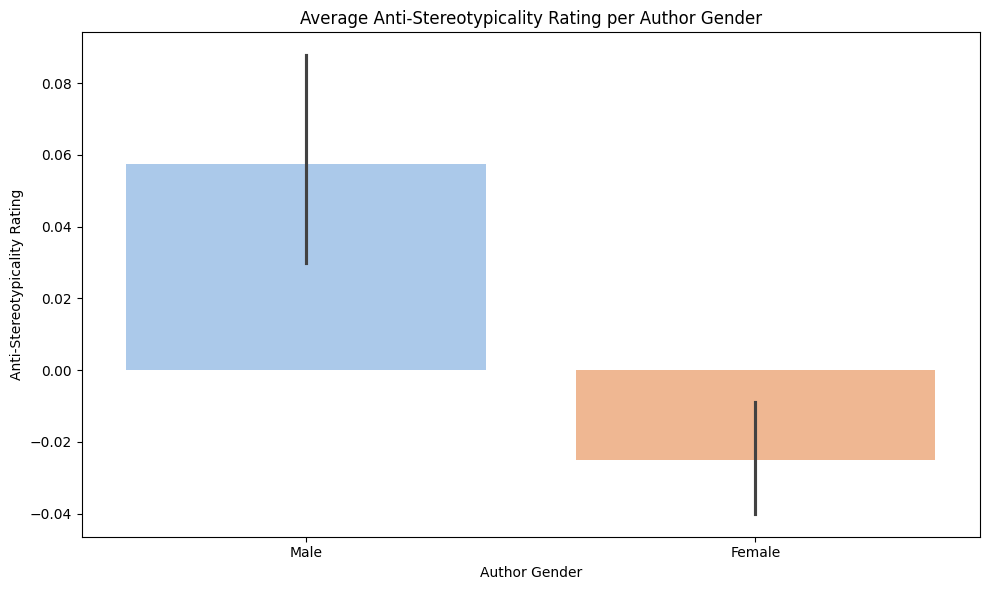

In [ ]:
# Author Gender ME - Neg - Plot
# Significance: C(author_gender)      1.838246      1.0    2.091072  1.481846e-01
# -> (NOT) significant

plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='author_gender', y='z_prop_neg', palette='pastel', errorbar=('ci', 90))

plt.title("Average Anti-Stereotypicality Rating per Author Gender")
plt.ylabel("Anti-Stereotypicality Rating")
plt.xlabel("Author Gender")
plt.tight_layout()
plt.show()

/var/folders/g_/q_msxx211pb8_18_mgg8djyr0000gn/T/ipykernel_2917/3797682273.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(data=df,


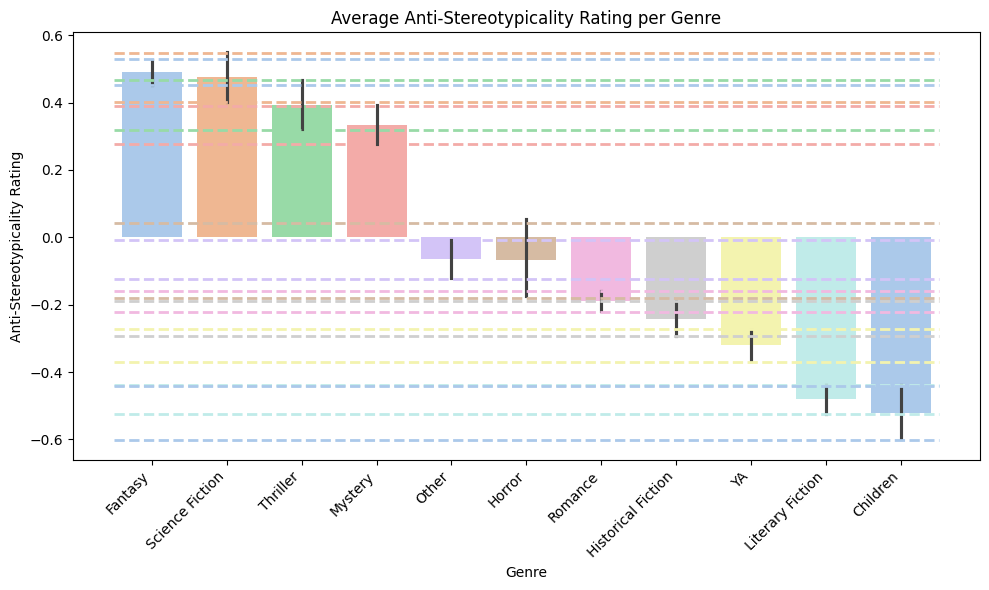

In [ ]:
# Genre ME - Neg - Plot

# Calculate means and confidence intervals per group
summary = df.groupby('master_genre')['z_prop_neg'].agg(['mean', 'count', 'std']).reset_index()
summary['sem'] = summary['std'] / summary['count']**0.5
summary['ci95'] = summary['sem'] * stats.t.ppf(0.975, df=summary['count']-1)  # 95% CI

# Sort genres by mean for consistent ordering
summary = summary.sort_values('mean', ascending=False)
order = summary['master_genre']

plt.figure(figsize=(10, 6))

# Plot bars with seaborn, ordered by 'order'
barplot = sns.barplot(data=df, 
                      x='master_genre', 
                      y='z_prop_neg', 
                      order=order, 
                      palette='pastel', 
                      errorbar=('ci', 95))

# Map bar colors to genres
bar_colors = {}
for patch in barplot.patches:
    # x coordinate is the bar index
    x_pos = int(patch.get_x() + patch.get_width() / 2 + 0.001)  # tiny offset to avoid float issues
    bar_colors[order.iloc[x_pos]] = patch.get_facecolor()

# Draw horizontal mean lines and two dashed lines for CI bounds
for _, row in summary.iterrows():
    genre = row['master_genre']
    mean = row['mean']
    ci = row['ci95']
    color = bar_colors[genre]
    
    # Lower CI bound dashed line
    plt.hlines(y=mean - ci, xmin=-0.5, xmax=len(summary)-0.5, colors=color, linestyles='dashed', linewidth=2)
    
    # Upper CI bound dashed line
    plt.hlines(y=mean + ci, xmin=-0.5, xmax=len(summary)-0.5, colors=color, linestyles='dashed', linewidth=2)

plt.title("Average Anti-Stereotypicality Rating per Genre")
plt.xticks(ticks=range(len(summary)), labels=order, rotation=45, ha='right')
plt.ylabel("Anti-Stereotypicality Rating")
plt.xlabel("Genre")
plt.tight_layout()
plt.show()

In [ ]:
# ONLINE SUPPLEMENT ONLY
# Genre ME - Neg - Significance Test 

# -- Which genres are significantly different from each other? --

# Drop NA values to avoid errors
df_clean = df[['master_genre', 'z_prop_neg']].dropna()

# Perform Tukey HSD
tukey = pairwise_tukeyhsd(endog=df_clean['z_prop_neg'],
                          groups=df_clean['master_genre'],
                          alpha=0.05)

print(tukey.summary())

            Multiple Comparison of Means - Tukey HSD, FWER=0.05             
      group1             group2       meandiff p-adj   lower   upper  reject
----------------------------------------------------------------------------
          Children            Fantasy    1.013    0.0  0.8284  1.1976   True
          Children Historical Fiction   0.2806 0.0001    0.09  0.4713   True
          Children             Horror   0.4533    0.0  0.2156   0.691   True
          Children   Literary Fiction   0.0406 0.9998 -0.1501  0.2312  False
          Children            Mystery   0.8558    0.0  0.6638  1.0478   True
          Children              Other   0.4567    0.0  0.2625  0.6508   True
          Children            Romance   0.3318    0.0  0.1507   0.513   True
          Children    Science Fiction   0.9968    0.0  0.7901  1.2036   True
          Children           Thriller    0.914    0.0  0.7149  1.1132   True
          Children                 YA   0.2011 0.0397  0.0045  0.3977   True

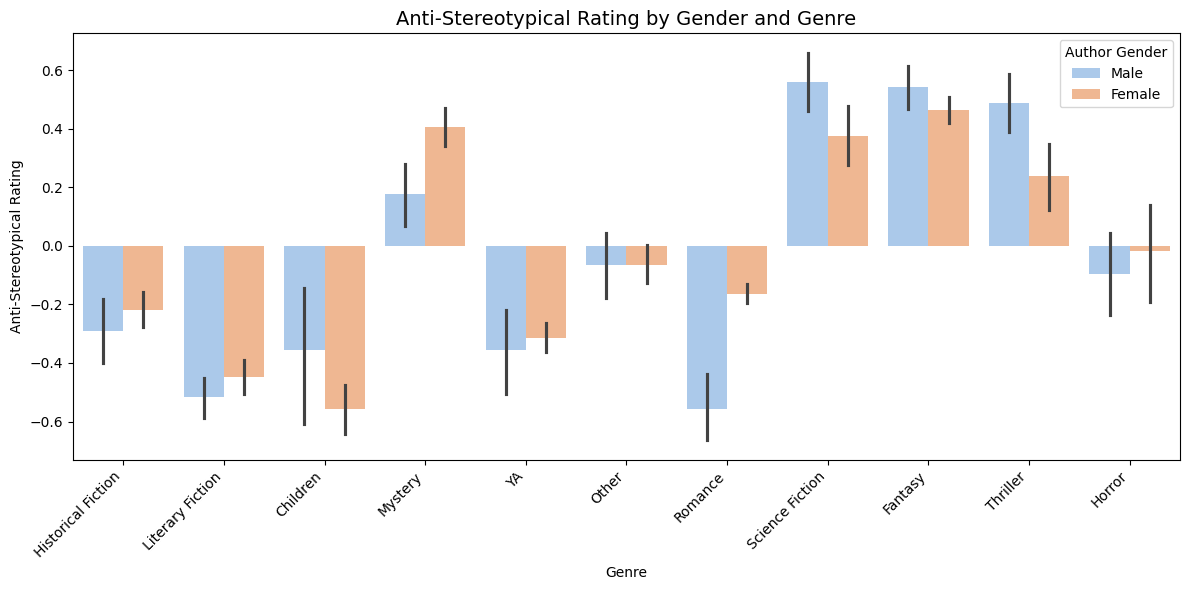

In [ ]:
# Interaction - Neg - Plot

plt.figure(figsize=(12, 6))

sns.barplot(
    data=df,
    x='master_genre',
    y='z_prop_neg',
    hue='author_gender',
    palette='pastel',
    errorbar=('ci', 95),
)

plt.xticks(rotation=45, ha='right')
plt.title("Anti-Stereotypical Rating by Gender and Genre", fontsize=14)
plt.ylabel("Anti-Stereotypical Rating")
plt.xlabel("Genre")
plt.legend(title="Author Gender")
plt.tight_layout()
plt.show()

In [ ]:
# ONLINE SUPPLEMENT ONLY
# Interaction - Neg - Significance Test

df_clean = df[['master_genre', 'author_gender', 'z_prop_neg']].dropna()

# Create interaction column
df_clean['interaction'] = df_clean['author_gender'].astype(str) + "_" + df_clean['master_genre'].astype(str)

# Run Tukey's HSD
tukey = pairwise_tukeyhsd(endog=df_clean['z_prop_neg'],
                          groups=df_clean['interaction'],
                          alpha=0.05)

print(tukey.summary())

/Users/hannes/Documents/svenjas paper/.venv/lib/python3.13/site-packages/scipy/integrate/_quadpack_py.py:1264: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


                   Multiple Comparison of Means - Tukey HSD, FWER=0.05                    
          group1                    group2          meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------------------------
          Female_Children            Female_Fantasy    1.023    0.0  0.7933  1.2526   True
          Female_Children Female_Historical Fiction   0.3385 0.0001  0.1007  0.5763   True
          Female_Children             Female_Horror   0.5387    0.0  0.1667  0.9106   True
          Female_Children   Female_Literary Fiction   0.1089 0.9942 -0.1365  0.3543  False
          Female_Children            Female_Mystery   0.9651    0.0  0.7248  1.2053   True
          Female_Children              Female_Other   0.4924    0.0  0.2488   0.736   True
          Female_Children            Female_Romance   0.3947    0.0  0.1736  0.6159   True
          Female_Children    Female_Science Fiction   0.9337    0.0  0.6512  1.2163   True

In [ ]:
# Author Gender*Genre - Neg - Effect size - Romance

# Subset the groups
group_female_romance = df[(df['author_gender'] == "Female") & (df['master_genre'] == "Romance")]['z_prop_neg']
group_male_romance = df[(df['author_gender'] == "Male") & (df['master_genre'] == "Romance")]['z_prop_neg']

# Calculate Cohen's d
d = pg.compute_effsize(group_female_romance, group_male_romance, eftype='cohen', paired=False)

print("Cohen's d:", d)

Cohen's d: 0.4452511599635998


In [ ]:
# Author Gender*Genre - Neg - Effect size - Mystery

# Subset the groups
group_female_mystery = df[(df['author_gender'] == "Female") & (df['master_genre'] == "Mystery")]['z_prop_neg']
group_male_mystery = df[(df['author_gender'] == "Male") & (df['master_genre'] == "Mystery")]['z_prop_neg']

# Calculate Cohen's d
d = pg.compute_effsize(group_female_mystery, group_male_mystery, eftype='cohen', paired=False)

print("Cohen's d:", d)

Cohen's d: 0.22518015780007092


In [ ]:
# Author Gender*Genre - Neg - Effect size - Thriller

# Subset the groups
group_female_thriller = df[(df['author_gender'] == "Female") & (df['master_genre'] == "Thriller")]['z_prop_neg']
group_male_thriller = df[(df['author_gender'] == "Male") & (df['master_genre'] == "Thriller")]['z_prop_neg']

# Calculate Cohen's d
d = pg.compute_effsize(group_female_thriller, group_male_thriller, eftype='cohen', paired=False)

print("Cohen's d:", d)

Cohen's d: -0.21958701023566332


## Item Groups
### Pro-Stereotypicality

In [31]:
# Define items
competence_agency_items_pos = ['Q4.answer', 'Q6.answer', 'Q8.answer',
                               'Q10.answer', 'Q12.answer', 'Q14.answer',
                               'Q16.answer']
warmth_communal_items_pos = ['Q18.answer', 'Q20.answer', 'Q22.answer',
                             'Q24.answer']
appearance_item_pos = ['Q26.answer']
lower_rank_item_pos = ['Q28.answer']

# Anzahl beurteilte (non‑NA) Items pro Zeile
n_competence_agency_pos = df[competence_agency_items_pos].notna().sum(axis=1)
n_warmth_communal_pos = df[warmth_communal_items_pos].notna().sum(axis=1)
n_appearance_item_pos = df[appearance_item_pos].notna().sum(axis=1)
n_lower_rank_item_pos = df[lower_rank_item_pos].notna().sum(axis=1)

# Anzahl Hits (1er) pro Zeile
sum_competence_agency_pos = df[competence_agency_items_pos].eq(1).sum(axis=1)
sum_warmth_communal_pos = df[warmth_communal_items_pos].eq(1).sum(axis=1)
sum_appearance_item_pos = df[appearance_item_pos].eq(1).sum(axis=1)
sum_lower_rank_item_pos = df[lower_rank_item_pos].eq(1).sum(axis=1)

# Filter out rows where the denominator would be zero to avoid NaNs
valid_rows = (n_competence_agency_pos > 0) & (n_warmth_communal_pos > 0) & \
             (n_appearance_item_pos > 0) & (n_lower_rank_item_pos > 0)
df_filtered = df[valid_rows].copy()

# Compute proportions safely
df_filtered['prop_competence_agency_pos'] = sum_competence_agency_pos[valid_rows] / n_competence_agency_pos[valid_rows]
df_filtered['prop_warmth_communal_pos'] = sum_warmth_communal_pos[valid_rows] / n_warmth_communal_pos[valid_rows]
df_filtered['prop_appearance_pos'] = df_filtered['Q26.answer']
df_filtered['prop_lower_rank_pos'] = df_filtered['Q28.answer']


### Anti-Stereotypicality

In [32]:
# Positive stereotype items
competence_agency_items_pos = ['Q4.answer', 'Q6.answer', 'Q8.answer',
                               'Q10.answer', 'Q12.answer', 'Q14.answer',
                               'Q16.answer']
warmth_communal_items_pos = ['Q18.answer', 'Q20.answer', 'Q22.answer',
                             'Q24.answer']
appearance_item_pos = ['Q26.answer']
lower_rank_item_pos = ['Q28.answer']

# Negative stereotype items
competence_agency_items_neg = ['Q5.answer', 'Q7.answer', 'Q9.answer',
                               'Q11.answer', 'Q13.answer', 'Q15.answer',
                               'Q17.answer']
warmth_communal_items_neg = ['Q19.answer', 'Q21.answer', 'Q23.answer',
                             'Q25.answer']
appearance_item_neg = ['Q27.answer']
lower_rank_item_neg = ['Q29.answer']

In [33]:
# Anzahl beurteilte (non‑NA) Items pro Zeile
n_pos = {
    'competence': df[competence_agency_items_pos].notna().sum(axis=1),
    'warmth': df[warmth_communal_items_pos].notna().sum(axis=1),
    'appearance': df[appearance_item_pos].notna().sum(axis=1),
    'lower_rank': df[lower_rank_item_pos].notna().sum(axis=1)
}
n_neg = {
    'competence': df[competence_agency_items_neg].notna().sum(axis=1),
    'warmth': df[warmth_communal_items_neg].notna().sum(axis=1),
    'appearance': df[appearance_item_neg].notna().sum(axis=1),
    'lower_rank': df[lower_rank_item_neg].notna().sum(axis=1)
}

# Anzahl Hits (1er)
sum_pos = {
    'competence': df[competence_agency_items_pos].eq(1).sum(axis=1),
    'warmth': df[warmth_communal_items_pos].eq(1).sum(axis=1),
    'appearance': df[appearance_item_pos].eq(1).sum(axis=1),
    'lower_rank': df[lower_rank_item_pos].eq(1).sum(axis=1)
}
sum_neg = {
    'competence': df[competence_agency_items_neg].eq(1).sum(axis=1),
    'warmth': df[warmth_communal_items_neg].eq(1).sum(axis=1),
    'appearance': df[appearance_item_neg].eq(1).sum(axis=1),
    'lower_rank': df[lower_rank_item_neg].eq(1).sum(axis=1)
}

In [34]:
valid_rows = (n_pos['competence'] > 0) & (n_pos['warmth'] > 0) & \
             (n_pos['appearance'] > 0) & (n_pos['lower_rank'] > 0) & \
             (n_neg['competence'] > 0) & (n_neg['warmth'] > 0) & \
             (n_neg['appearance'] > 0) & (n_neg['lower_rank'] > 0)

df_filtered = df[valid_rows].copy()

In [35]:
# Positive proportions
df_filtered['prop_competence_agency_pos'] = sum_pos['competence'][valid_rows] / n_pos['competence'][valid_rows]
df_filtered['prop_warmth_communal_pos'] = sum_pos['warmth'][valid_rows] / n_pos['warmth'][valid_rows]
df_filtered['prop_appearance_pos'] = df_filtered['Q26.answer']
df_filtered['prop_lower_rank_pos'] = df_filtered['Q28.answer']

# Negative proportions
df_filtered['prop_competence_agency_neg'] = sum_neg['competence'][valid_rows] / n_neg['competence'][valid_rows]
df_filtered['prop_warmth_communal_neg'] = sum_neg['warmth'][valid_rows] / n_neg['warmth'][valid_rows]
df_filtered['prop_appearance_neg'] = df_filtered['Q27.answer']
df_filtered['prop_lower_rank_neg'] = df_filtered['Q29.answer']

In [36]:
from scipy.stats import zscore

# Z-standardize the positive proportions (column-wise)
df_filtered['z_competence_agency_pos'] = zscore(df_filtered['prop_competence_agency_pos'])
df_filtered['z_warmth_communal_pos'] = zscore(df_filtered['prop_warmth_communal_pos'])
df_filtered['z_appearance_pos'] = zscore(df_filtered['prop_appearance_pos'])
df_filtered['z_lower_rank_pos'] = zscore(df_filtered['prop_lower_rank_pos'])

# Z-standardize the negative proportions (column-wise)
df_filtered['z_competence_agency_neg'] = zscore(df_filtered['prop_competence_agency_neg'])
df_filtered['z_warmth_communal_neg'] = zscore(df_filtered['prop_warmth_communal_neg'])
df_filtered['z_appearance_neg'] = zscore(df_filtered['prop_appearance_neg'])
df_filtered['z_lower_rank_neg'] = zscore(df_filtered['prop_lower_rank_neg'])

# Compute net scores (positive minus negative) for each dimension
df_filtered['net_competence_agency'] = df_filtered['z_competence_agency_pos'] - df_filtered['z_competence_agency_neg']
df_filtered['net_warmth_communal'] = df_filtered['z_warmth_communal_pos'] - df_filtered['z_warmth_communal_neg']
df_filtered['net_appearance'] = df_filtered['z_appearance_pos'] - df_filtered['z_appearance_neg']
df_filtered['net_lower_rank'] = df_filtered['z_lower_rank_pos'] - df_filtered['z_lower_rank_neg']

#### Regressions

In [ ]:
#svenjas code

blocks = ['net_competence_agency', 'net_warmth_communal', 'net_appearance', 'net_lower_rank']

results = {}
summary_list = []

for block in blocks:
    formula = f'{block} ~ C(author_gender) * C(master_genre)'
    model = smf.ols(formula, data=df_filtered).fit()

    pvals = model.pvalues
    print(pvals)
    break
    
    gender_significant = any([term.startswith('C(author_gender)') and pvals[term] < 0.05 
                              for term in pvals.index if ':' not in term])
    
    genre_significant = any([term.startswith('C(master_genre)') and ':' not in term and pvals[term] < 0.05
                             for term in pvals.index])
    
    interaction_significant = any([':' in term and ('C(author_gender)' in term and 'C(master_genre)' in term) and pvals[term] < 0.05
                                  for term in pvals.index])
    
    summary_list.append({
        'Block': block,
        'Gender_significant': gender_significant,
        'Genre_significant': genre_significant,
        'Interaction_significant': interaction_significant
    })

summary_df = pd.DataFrame(summary_list)

print(summary_df)

In [53]:
#hannes code
blocks = ['net_competence_agency', 'net_warmth_communal', 'net_appearance', 'net_lower_rank']

results = {}
summary_list = []

for block in blocks:
    for genre in df_filtered['master_genre'].unique():
            # Subset data for the current genre
            df_genre = df_filtered[df_filtered['master_genre'] == genre]
            # Fit model: block ~ C(author_gender)
            formula = f'{block} ~ C(author_gender)'
            model = smf.ols(formula, data=df_genre).fit()
            results[(block, genre)] = model

            # Get p-value for gender effect
            pvals = model.pvalues
            gender_term = [term for term in pvals.index if term.startswith('C(author_gender)')]
            # Save coefficient for gender effect (Female vs Male)
            coef = model.params[gender_term[0]] if gender_term else None
            #save confidence interval
            ci = model.conf_int().loc[gender_term[0]] if gender_term else None

            summary_list.append({
                'Block': block,
                'Genre': genre,
                'Gender_effect': coef,
                'CI_lower': ci[0] if ci is not None else None,
                'CI_upper': ci[1] if ci is not None else None,
                'p_value': pvals[gender_term[0]] if gender_term else None
            })

summary_df = pd.DataFrame(summary_list)

print(summary_df)

                    Block               Genre  Gender_effect  CI_lower  \
0   net_competence_agency  Historical Fiction       0.039068 -0.162708   
1   net_competence_agency            Children       0.636414  0.238619   
2   net_competence_agency             Mystery      -0.568046 -0.791581   
3   net_competence_agency    Literary Fiction       0.058566 -0.099398   
4   net_competence_agency             Romance       0.134293 -0.097469   
5   net_competence_agency             Fantasy       0.216539  0.060810   
6   net_competence_agency     Science Fiction       0.002925 -0.271057   
7   net_competence_agency            Thriller      -0.208784 -0.498009   
8   net_competence_agency                  YA       0.231481 -0.024985   
9   net_competence_agency               Other       0.231804 -0.003973   
10  net_competence_agency              Horror      -0.202422 -0.652059   
11    net_warmth_communal  Historical Fiction       0.093599 -0.170460   
12    net_warmth_communal            C

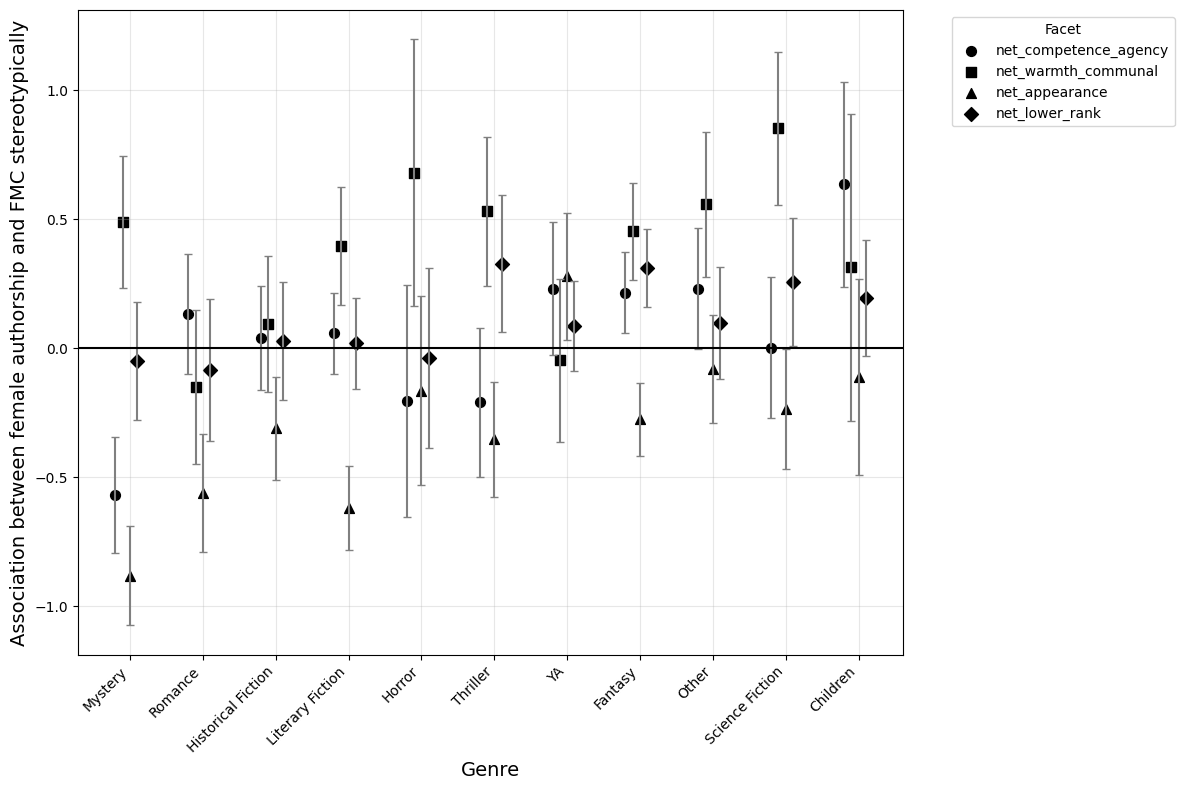

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up plot
plt.figure(figsize=(12, 8))

# Unique blocks and markers for each
markers = ['o', 's', '^', 'D']
blocks = summary_df['Block'].unique()

# Compute sum of Gender_effect per genre and sort genres accordingly
genre_sums = summary_df.groupby('Genre')['Gender_effect'].sum().sort_values()
genres = genre_sums.index.tolist()  # Sorted genres by sum of Gender_effect

# Increase spacing between genres
genre_spacing = 2
genre_to_x = {genre: i * genre_spacing for i, genre in enumerate(genres)}

# Width of dodge (spread between blocks within each genre)
dodge_width = 0.2
offsets = [((i - len(blocks) / 2)) * dodge_width for i in range(len(blocks))]

# Plot each block manually with error bars
for i, block in enumerate(blocks):
    block_data = summary_df[summary_df['Block'] == block]
    
    for _, row in block_data.iterrows():
        genre = row['Genre']
        x = genre_to_x[genre] + offsets[i]
        y = row['Gender_effect']
        yerr_lower = y - row['CI_lower']
        yerr_upper = row['CI_upper'] - y
        
        # Plot point
        plt.scatter(x, y, marker=markers[i], s=50, color='black', label=block if x == genre_to_x[genres[0]] + offsets[i] else "")

        # Plot error bar
        plt.errorbar(x, y, yerr=[[yerr_lower], [yerr_upper]], fmt='none', ecolor='gray', capsize=3)

# Formatting x-axis
xticks = [genre_to_x[genre] for genre in genres]
plt.xticks(ticks=xticks, labels=genres, rotation=45, ha='right')

# Final touches
plt.xlabel('Genre', fontsize=14)
plt.ylabel('Association between female authorship and FMC stereotypically', fontsize=14)
plt.axhline(y=0, color='black', linestyle='-')
plt.legend(title='Facet', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../visualizations/Figure 7.png', dpi=300)
plt.show()


##### Competence-Agency

In [73]:
# With interaction -> ag*g still significant
model_me_i = smf.ols('net_competence_agency ~ C(author_gender) * C(master_genre)', data=df_filtered).fit()
anova_model_me_i = anova_lm(model_me_i, typ=3)
print(anova_model_me_i)

                                        sum_sq       df          F  \
Intercept                            22.042219      1.0  10.135277   
C(author_gender)                     15.210714      1.0   6.994069   
C(master_genre)                     316.968946     10.0  14.574613   
C(author_gender):C(master_genre)    112.354421     10.0   5.166191   
Residual                          22063.363657  10145.0        NaN   

                                        PR(>F)  
Intercept                         1.458977e-03  
C(author_gender)                  8.190616e-03  
C(master_genre)                   4.437117e-26  
C(author_gender):C(master_genre)  1.381545e-07  
Residual                                   NaN  


In [74]:
# ANOVA for easier reporting of categorical predictor results
# Effect Sizes
anova = pg.anova(
    data=df_filtered,
    dv='net_competence_agency',
    between=['author_gender', 'master_genre'],
    detailed=True
)

print(anova)

# Effect size author gender: 0.000110
# Effect size genre: 0.055991
# Effect size author gender*genre: 0.005067

                         Source            SS       DF          MS          F  \
0                 author_gender      2.433415      1.0    2.433415   1.118914   
1                  master_genre   1308.611344     10.0  130.861134  60.171524   
2  author_gender * master_genre    112.354421     10.0   11.235442   5.166191   
3                      Residual  22063.363657  10145.0    2.174802        NaN   

           p-unc       np2  
0   2.901777e-01  0.000110  
1  3.214543e-119  0.055991  
2   1.381545e-07  0.005067  
3            NaN       NaN  


/var/folders/g_/q_msxx211pb8_18_mgg8djyr0000gn/T/ipykernel_2917/1957803439.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_filtered, x='author_gender', y='net_competence_agency', palette='pastel', errorbar=('ci', 95))


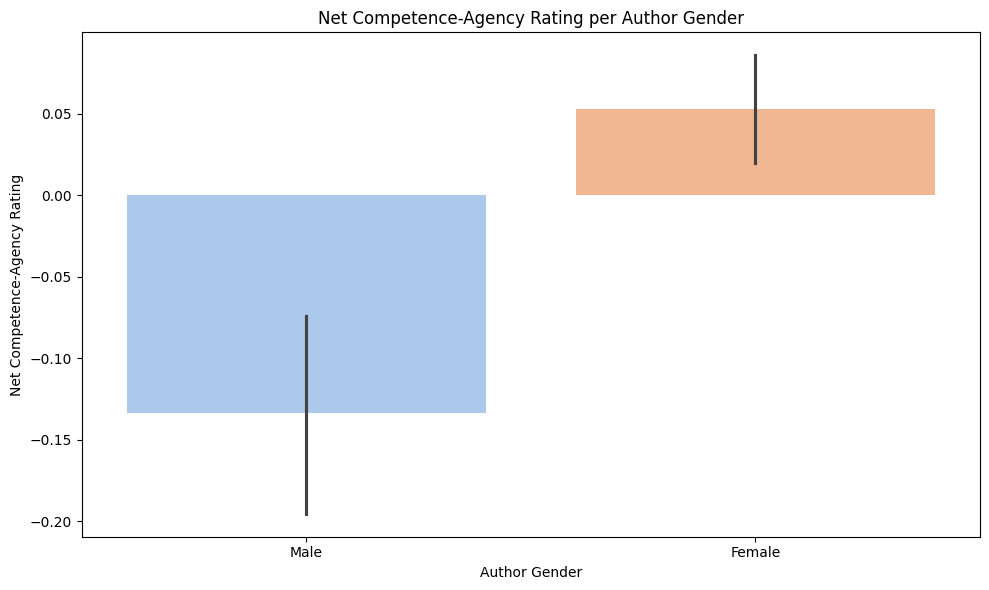

In [75]:
# Author Gender - Plot

plt.figure(figsize=(10, 6))
sns.barplot(data=df_filtered, x='author_gender', y='net_competence_agency', palette='pastel', errorbar=('ci', 95))

plt.title("Net Competence-Agency Rating per Author Gender")
plt.ylabel("Net Competence-Agency Rating")
plt.xlabel("Author Gender")
plt.tight_layout()
plt.show()

In [76]:
# Author Gender - Effect size

# Subset the groups
group_female_agency = df_filtered[df_filtered['author_gender'] == "Female"]['net_competence_agency']
group_male_agency = df_filtered[df_filtered['author_gender'] == "Male"]['net_competence_agency']

# Calculate Cohen's d
d = pg.compute_effsize(group_female_agency, group_male_agency, eftype='cohen', paired=False)

print("Cohen's d:", d)

Cohen's d: 0.12265778324157992


/var/folders/g_/q_msxx211pb8_18_mgg8djyr0000gn/T/ipykernel_2917/2958376061.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(data=df_filtered,


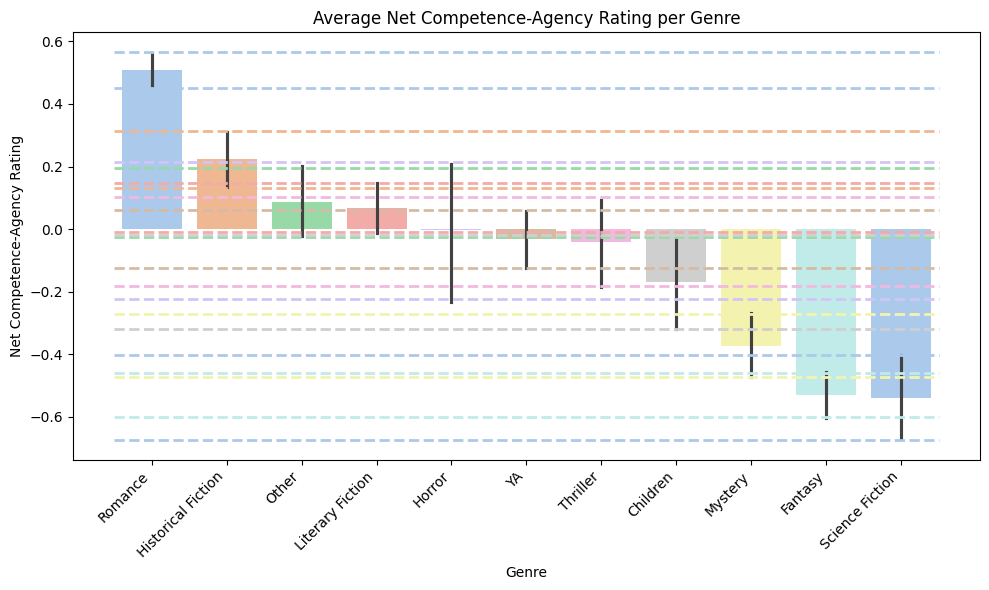

In [77]:
# Genre ME - Neg - Plot

# Calculate means and confidence intervals per group
summary = df_filtered.groupby('master_genre')['net_competence_agency'].agg(['mean', 'count', 'std']).reset_index()
summary['sem'] = summary['std'] / summary['count']**0.5
summary['ci95'] = summary['sem'] * stats.t.ppf(0.975, df=summary['count']-1)  # 95% CI

# Sort genres by mean for consistent ordering
summary = summary.sort_values('mean', ascending=False)
order = summary['master_genre']

plt.figure(figsize=(10, 6))

# Plot bars with seaborn, ordered by 'order'
barplot = sns.barplot(data=df_filtered, 
                      x='master_genre', 
                      y='net_competence_agency', 
                      order=order, 
                      palette='pastel', 
                      errorbar=('ci', 95))

# Map bar colors to genres
bar_colors = {}
for patch in barplot.patches:
    # x coordinate is the bar index
    x_pos = int(patch.get_x() + patch.get_width() / 2 + 0.001)  # tiny offset to avoid float issues
    bar_colors[order.iloc[x_pos]] = patch.get_facecolor()

# Draw horizontal mean lines and two dashed lines for CI bounds
for _, row in summary.iterrows():
    genre = row['master_genre']
    mean = row['mean']
    ci = row['ci95']
    color = bar_colors[genre]
    
    # Lower CI bound dashed line
    plt.hlines(y=mean - ci, xmin=-0.5, xmax=len(summary)-0.5, colors=color, linestyles='dashed', linewidth=2)
    
    # Upper CI bound dashed line
    plt.hlines(y=mean + ci, xmin=-0.5, xmax=len(summary)-0.5, colors=color, linestyles='dashed', linewidth=2)

plt.title("Average Net Competence-Agency Rating per Genre")
plt.xticks(ticks=range(len(summary)), labels=order, rotation=45, ha='right')
plt.ylabel("Net Competence-Agency Rating")
plt.xlabel("Genre")
plt.tight_layout()
plt.show()

Competence Agency
Romance, historical fiction
fantasy, science fiction

In [78]:
# ONLINE SUPPLEMENT ONLY
# Genre ME - Significance Test 

# Drop NA values to avoid errors
df_clean = df_filtered[['master_genre', 'net_competence_agency']].dropna()

# Perform Tukey HSD
tukey = pairwise_tukeyhsd(endog=df_clean['net_competence_agency'],
                          groups=df_clean['master_genre'],
                          alpha=0.05)

print(tukey.summary())



            Multiple Comparison of Means - Tukey HSD, FWER=0.05             
      group1             group2       meandiff p-adj   lower   upper  reject
----------------------------------------------------------------------------
          Children            Fantasy  -0.3617  0.009 -0.6742 -0.0492   True
          Children Historical Fiction   0.3915 0.0048  0.0677  0.7153   True
          Children             Horror   0.1646  0.976 -0.2577  0.5868  False
          Children   Literary Fiction   0.2365 0.3842 -0.0843  0.5574  False
          Children            Mystery  -0.2037 0.6614 -0.5344  0.1271  False
          Children              Other   0.2543 0.3351 -0.0799  0.5884  False
          Children            Romance   0.6772    0.0   0.372  0.9824   True
          Children    Science Fiction    -0.37  0.032 -0.7244 -0.0157   True
          Children           Thriller   0.1283 0.9846 -0.2216  0.4782  False
          Children                 YA   0.1372 0.9633 -0.1944  0.4688  False

/var/folders/g_/q_msxx211pb8_18_mgg8djyr0000gn/T/ipykernel_2917/378243584.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means_by_genre_gender = df_filtered.groupby(['master_genre', 'author_gender'])['net_competence_agency'].mean().unstack()
/var/folders/g_/q_msxx211pb8_18_mgg8djyr0000gn/T/ipykernel_2917/378243584.py:47: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = genre_data.groupby('author_gender')['net_competence_agency'].mean()


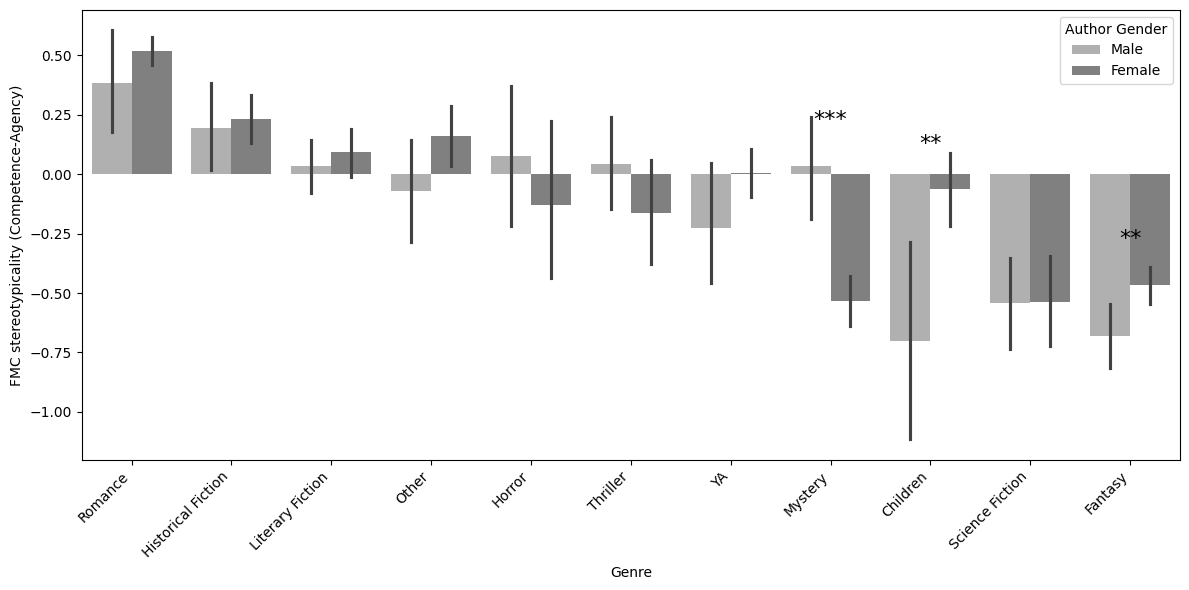

In [136]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Calculate mean net_competence_agency for each genre and gender
means_by_genre_gender = df_filtered.groupby(['master_genre', 'author_gender'])['net_competence_agency'].mean().unstack()

# Sum male and female means for each genre
genre_order = (means_by_genre_gender['Male'] + means_by_genre_gender['Female']).sort_values(ascending=False).index

plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=df_filtered,
    x='master_genre',
    y='net_competence_agency',
    hue='author_gender',
    palette=gray_colors,
    errorbar=('ci', 95),
    order=genre_order
)
plt.xticks(rotation=45, ha='right')
plt.ylabel("FMC stereotypicality (Competence-Agency)")
plt.xlabel("Genre")
plt.legend(title="Author Gender")
plt.tight_layout()

# Add significance stars for gender difference within each genre

for i, genre in enumerate(genre_order):
    genre_data = df_filtered[df_filtered['master_genre'] == genre]
    tukey = pairwise_tukeyhsd(endog=genre_data['net_competence_agency'],
                              groups=genre_data['author_gender'],
                              alpha=0.05)
    # Get p-value for Male vs Female
    try:
        pval = tukey.pvalues[0]
    except Exception:
        pval = np.nan
    # Determine number of stars
    if pval < 0.001:
        stars = '***'
    elif pval < 0.01:
        stars = '**'
    elif pval < 0.05:
        stars = '*'
    else:
        stars = ''
    # Get bar heights for annotation
    means = genre_data.groupby('author_gender')['net_competence_agency'].mean()
    y_max = means.max()
    # Annotate above the bars
    ax.text(i, y_max + 0.15, stars, ha='center', va='bottom', fontsize=16, color='black')

plt.savefig("../visualizations/Figure 6.png", dpi=300)
plt.show()


In [80]:
# ONLINE SUPPLEMENT ONLY
# Interaction - Comp/agencey  - Significance Test

df_clean = df_filtered[['master_genre', 'author_gender', 'net_competence_agency']].dropna()

# Create interaction column
df_clean['interaction'] = df_clean['author_gender'].astype(str) + "_" + df_clean['master_genre'].astype(str)

# Run Tukey's HSD
tukey = pairwise_tukeyhsd(endog=df_clean['net_competence_agency'],
                          groups=df_clean['interaction'],
                          alpha=0.05)

print(tukey.summary())

/Users/hannes/Documents/svenjas paper/.venv/lib/python3.13/site-packages/scipy/integrate/_quadpack_py.py:1264: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


                   Multiple Comparison of Means - Tukey HSD, FWER=0.05                    
          group1                    group2          meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------------------------
          Female_Children            Female_Fantasy  -0.4012 0.0315 -0.7879 -0.0146   True
          Female_Children Female_Historical Fiction   0.2971 0.5037 -0.1041  0.6982  False
          Female_Children             Female_Horror   -0.064    1.0 -0.7166  0.5885  False
          Female_Children   Female_Literary Fiction   0.1574 0.9992 -0.2525  0.5674  False
          Female_Children            Female_Mystery  -0.4692 0.0078 -0.8803 -0.0581   True
          Female_Children              Female_Other   0.2242 0.9515 -0.1954  0.6438  False
          Female_Children            Female_Romance   0.5811    0.0   0.211  0.9512   True
          Female_Children    Female_Science Fiction  -0.4738 0.0627  -0.957  0.0094  False

In [81]:
# Author Gender*Genre - Comp/agencey - Effect size - Mystery

# Subset the groups
group_female_thriller = df_filtered[(df_filtered['author_gender'] == "Female") & (df_filtered['master_genre'] == "Mystery")]['net_competence_agency']
group_male_thriller = df_filtered[(df_filtered['author_gender'] == "Male") & (df_filtered['master_genre'] == "Mystery")]['net_competence_agency']

# Calculate Cohen's d
d = pg.compute_effsize(group_female_thriller, group_male_thriller, eftype='cohen', paired=False)

print("Cohen's d:", d)

Cohen's d: -0.3768439544360294


In [82]:
# Author Gender*Genre - Comp/agencey - Effect size - Fantasy

# Subset the groups
group_female_thriller = df_filtered[(df_filtered['author_gender'] == "Female") & (df_filtered['master_genre'] == "Fantasy")]['net_competence_agency']
group_male_thriller = df_filtered[(df_filtered['author_gender'] == "Male") & (df_filtered['master_genre'] == "Fantasy")]['net_competence_agency']

# Calculate Cohen's d
d = pg.compute_effsize(group_female_thriller, group_male_thriller, eftype='cohen', paired=False)

print("Cohen's d:", d)

Cohen's d: 0.1498202315754146


##### Net Warmth-Communality

In [83]:
# ANOVA for easier reporting of categorical predictor results
# Effect Sizes
anova = pg.anova(
    data=df_filtered,
    dv='net_warmth_communal',
    between=['author_gender', 'master_genre'],
    detailed=True
)

print(anova)

# Effect size author gender: 0.007497
# Effect size genre: 0.050913
# Effect size author gender*genre: 0.003714

                         Source            SS       DF          MS          F  \
0                 author_gender    255.017423      1.0  255.017423  76.630816   
1                  master_genre   1811.112040     10.0  181.111204  54.422553   
2  author_gender * master_genre    125.845997     10.0   12.584600   3.781577   
3                      Residual  33761.245220  10145.0    3.327870        NaN   

           p-unc       np2  
0   2.389080e-18  0.007497  
1  1.442103e-107  0.050913  
2   4.177515e-05  0.003714  
3            NaN       NaN  


/var/folders/g_/q_msxx211pb8_18_mgg8djyr0000gn/T/ipykernel_2917/3345543596.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(data=df_filtered,


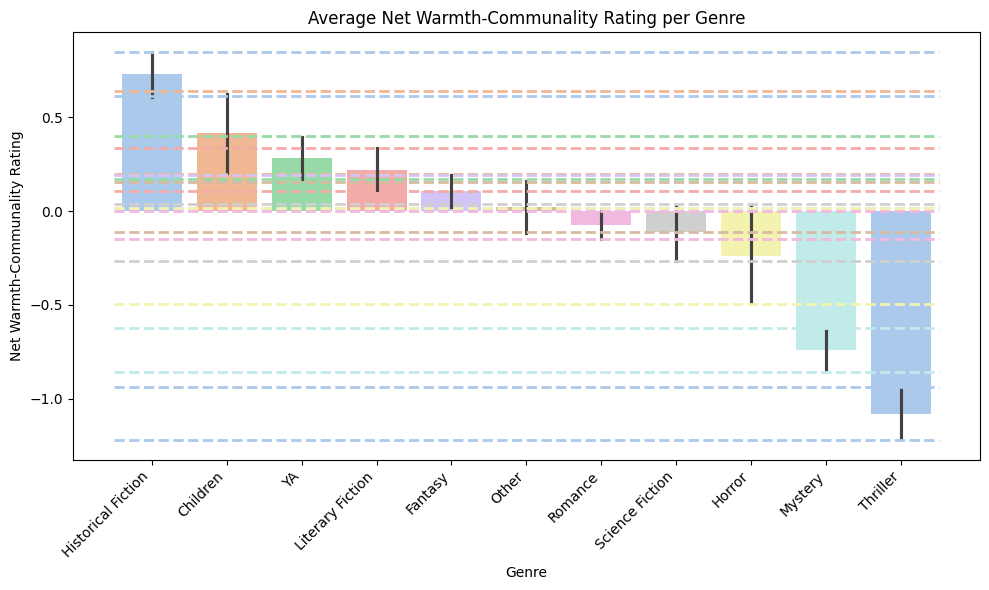

In [84]:
# Genre ME - Neg - Plot

# Calculate means and confidence intervals per group
summary = df_filtered.groupby('master_genre')['net_warmth_communal'].agg(['mean', 'count', 'std']).reset_index()
summary['sem'] = summary['std'] / summary['count']**0.5
summary['ci95'] = summary['sem'] * stats.t.ppf(0.975, df=summary['count']-1)  # 95% CI

# Sort genres by mean for consistent ordering
summary = summary.sort_values('mean', ascending=False)
order = summary['master_genre']

plt.figure(figsize=(10, 6))

# Plot bars with seaborn, ordered by 'order'
barplot = sns.barplot(data=df_filtered, 
                      x='master_genre', 
                      y='net_warmth_communal', 
                      order=order, 
                      palette='pastel', 
                      errorbar=('ci', 95))

# Map bar colors to genres
bar_colors = {}
for patch in barplot.patches:
    # x coordinate is the bar index
    x_pos = int(patch.get_x() + patch.get_width() / 2 + 0.001)  # tiny offset to avoid float issues
    bar_colors[order.iloc[x_pos]] = patch.get_facecolor()

# Draw horizontal mean lines and two dashed lines for CI bounds
for _, row in summary.iterrows():
    genre = row['master_genre']
    mean = row['mean']
    ci = row['ci95']
    color = bar_colors[genre]
    
    # Lower CI bound dashed line
    plt.hlines(y=mean - ci, xmin=-0.5, xmax=len(summary)-0.5, colors=color, linestyles='dashed', linewidth=2)
    
    # Upper CI bound dashed line
    plt.hlines(y=mean + ci, xmin=-0.5, xmax=len(summary)-0.5, colors=color, linestyles='dashed', linewidth=2)

plt.title("Average Net Warmth-Communality Rating per Genre")
plt.xticks(ticks=range(len(summary)), labels=order, rotation=45, ha='right')
plt.ylabel("Net Warmth-Communality Rating")
plt.xlabel("Genre")
plt.tight_layout()
plt.show()

Warmth-Communality
Historical Fiction, Children 
Thriller, Mystery 

In [85]:
# ONLINE SUPPLEMENT ONLY
# Genre ME - Significance Test 

# Drop NA values to avoid errors
df_clean = df_filtered[['master_genre', 'net_warmth_communal']].dropna()

# Perform Tukey HSD
tukey = pairwise_tukeyhsd(endog=df_clean['net_warmth_communal'],
                          groups=df_clean['master_genre'],
                          alpha=0.05)

print(tukey.summary())

# Convert Tukey results to a DataFrame
tukey_results = pd.DataFrame(
    data=tukey._results_table.data[1:],  # Skip header
    columns=tukey._results_table.data[0]  # Column names
)
tukey_results.to_latex('tukey_results.tex', index=False)

            Multiple Comparison of Means - Tukey HSD, FWER=0.05             
      group1             group2       meandiff p-adj   lower   upper  reject
----------------------------------------------------------------------------
          Children            Fantasy  -0.3114 0.2561 -0.6992  0.0763  False
          Children Historical Fiction   0.3133  0.298 -0.0884  0.7151  False
          Children             Horror  -0.6574 0.0026 -1.1813 -0.1335   True
          Children   Literary Fiction  -0.1956 0.8904 -0.5936  0.2025  False
          Children            Mystery  -1.1564    0.0 -1.5668 -0.7461   True
          Children              Other  -0.3946 0.0789 -0.8093    0.02  False
          Children            Romance   -0.491 0.0015 -0.8696 -0.1123   True
          Children    Science Fiction  -0.5293 0.0051  -0.969 -0.0895   True
          Children           Thriller  -1.4943    0.0 -1.9285 -1.0602   True
          Children                 YA  -0.1323 0.9945 -0.5437  0.2791  False

##### Net Appearance

In [86]:
# ANOVA for easier reporting of categorical predictor results
# Effect Sizes
anova = pg.anova(
    data=df_filtered,
    dv='net_appearance',
    between=['author_gender', 'master_genre'],
    detailed=True
)

print(anova)

# Effect size author gender: 0.007497
# Effect size genre: 0.050913
# Effect size author gender*genre: 0.003714

                         Source            SS       DF          MS  \
0                 author_gender    231.395241      1.0  231.395241   
1                  master_genre   1496.734185     10.0  149.673418   
2  author_gender * master_genre    140.289438     10.0   14.028944   
3                      Residual  19119.321215  10145.0    1.884605   

            F          p-unc       np2  
0  122.781803   2.263743e-28  0.011958  
1   79.418972  7.095932e-158  0.072600  
2    7.443969   6.816722e-12  0.007284  
3         NaN            NaN       NaN  


/var/folders/g_/q_msxx211pb8_18_mgg8djyr0000gn/T/ipykernel_2917/1905878651.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(data=df_filtered,


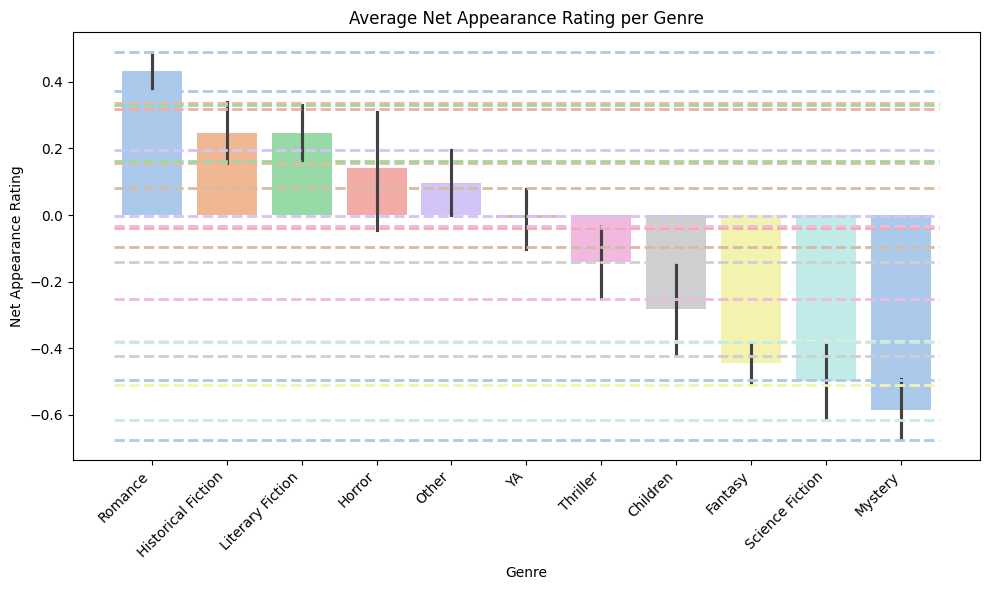

In [87]:
# Genre ME - Neg - Plot

# Calculate means and confidence intervals per group
summary = df_filtered.groupby('master_genre')['net_appearance'].agg(['mean', 'count', 'std']).reset_index()
summary['sem'] = summary['std'] / summary['count']**0.5
summary['ci95'] = summary['sem'] * stats.t.ppf(0.975, df=summary['count']-1)  # 95% CI

# Sort genres by mean for consistent ordering
summary = summary.sort_values('mean', ascending=False)
order = summary['master_genre']

plt.figure(figsize=(10, 6))

# Plot bars with seaborn, ordered by 'order'
barplot = sns.barplot(data=df_filtered, 
                      x='master_genre', 
                      y='net_appearance', 
                      order=order, 
                      palette='pastel', 
                      errorbar=('ci', 95))

# Map bar colors to genres
bar_colors = {}
for patch in barplot.patches:
    # x coordinate is the bar index
    x_pos = int(patch.get_x() + patch.get_width() / 2 + 0.001)  # tiny offset to avoid float issues
    bar_colors[order.iloc[x_pos]] = patch.get_facecolor()

# Draw horizontal mean lines and two dashed lines for CI bounds
for _, row in summary.iterrows():
    genre = row['master_genre']
    mean = row['mean']
    ci = row['ci95']
    color = bar_colors[genre]
    
    # Lower CI bound dashed line
    plt.hlines(y=mean - ci, xmin=-0.5, xmax=len(summary)-0.5, colors=color, linestyles='dashed', linewidth=2)
    
    # Upper CI bound dashed line
    plt.hlines(y=mean + ci, xmin=-0.5, xmax=len(summary)-0.5, colors=color, linestyles='dashed', linewidth=2)

plt.title("Average Net Appearance Rating per Genre")
plt.xticks(ticks=range(len(summary)), labels=order, rotation=45, ha='right')
plt.ylabel("Net Appearance Rating")
plt.xlabel("Genre")
plt.tight_layout()
plt.show()

appearance
romance, historical fiction, literary fiction
mystery, science fiction, fantsay

In [88]:
# ONLINE SUPPLEMENT ONLY
# Genre ME - Significance Test 

# Drop NA values to avoid errors
df_clean = df_filtered[['master_genre', 'net_appearance']].dropna()

# Perform Tukey HSD
tukey = pairwise_tukeyhsd(endog=df_clean['net_appearance'],
                          groups=df_clean['master_genre'],
                          alpha=0.05)

print(tukey.summary())

# Convert Tukey results to a DataFrame
tukey_results = pd.DataFrame(
    data=tukey._results_table.data[1:],  # Skip header
    columns=tukey._results_table.data[0]  # Column names
)
tukey_results.to_latex('tukey_results.tex', index=False)

            Multiple Comparison of Means - Tukey HSD, FWER=0.05             
      group1             group2       meandiff p-adj   lower   upper  reject
----------------------------------------------------------------------------
          Children            Fantasy  -0.1613 0.7963 -0.4543  0.1316  False
          Children Historical Fiction   0.5289    0.0  0.2254  0.8325   True
          Children             Horror   0.4231 0.0246  0.0272  0.8189   True
          Children   Literary Fiction   0.5285    0.0  0.2277  0.8293   True
          Children            Mystery  -0.3027 0.0628 -0.6127  0.0074  False
          Children              Other   0.3799 0.0046  0.0666  0.6932   True
          Children            Romance   0.7152    0.0  0.4291  1.0013   True
          Children    Science Fiction   -0.215  0.589 -0.5473  0.1172  False
          Children           Thriller   0.1411 0.9522 -0.1869  0.4692  False
          Children                 YA   0.2757  0.138 -0.0352  0.5865  False

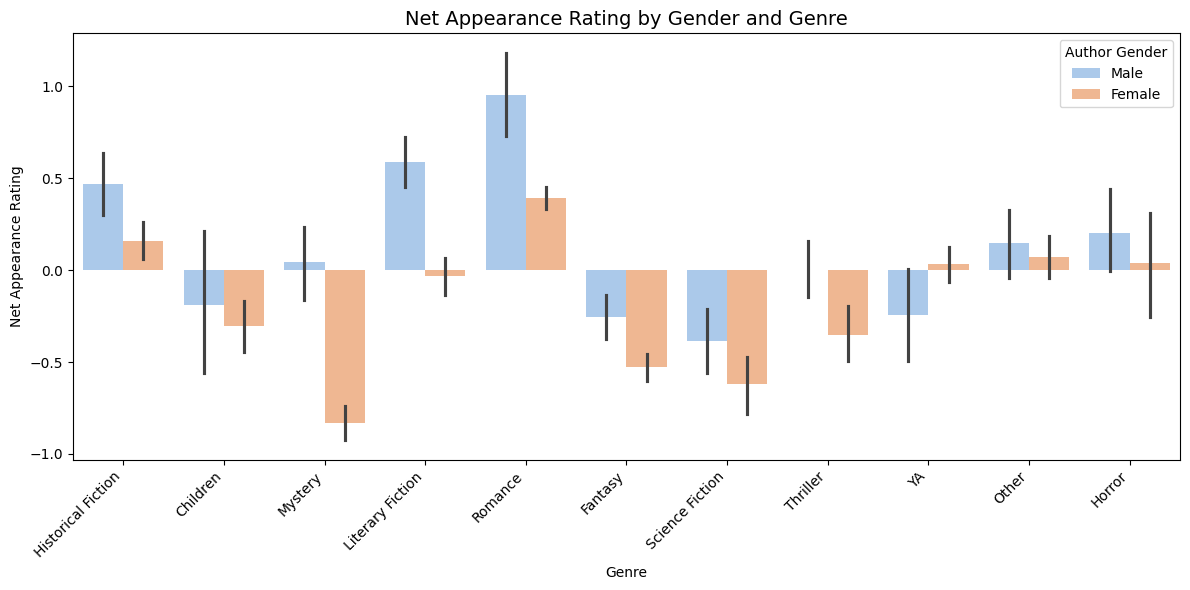

In [89]:
# Interaction - Plot

plt.figure(figsize=(12, 6))

sns.barplot(
    data=df_filtered,
    x='master_genre',
    y='net_appearance',
    hue='author_gender',
    palette='pastel',
    errorbar=('ci', 95),
)

plt.xticks(rotation=45, ha='right')
plt.title("Net Appearance Rating by Gender and Genre", fontsize=14)
plt.ylabel("Net Appearance Rating")
plt.xlabel("Genre")
plt.legend(title="Author Gender")
plt.tight_layout()
plt.show()

In [90]:
# ONLINE SUPPLEMENT ONLY
# Interaction - Appearance  - Significance Test

df_clean = df_filtered[['master_genre', 'author_gender', 'net_appearance']].dropna()

# Create interaction column
df_clean['interaction'] = df_clean['author_gender'].astype(str) + "_" + df_clean['master_genre'].astype(str)

# Run Tukey's HSD
tukey = pairwise_tukeyhsd(endog=df_clean['net_appearance'],
                          groups=df_clean['interaction'],
                          alpha=0.05)

print(tukey.summary())

/Users/hannes/Documents/svenjas paper/.venv/lib/python3.13/site-packages/scipy/integrate/_quadpack_py.py:1264: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


                   Multiple Comparison of Means - Tukey HSD, FWER=0.05                    
          group1                    group2          meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------------------------
          Female_Children            Female_Fantasy  -0.2266 0.8026 -0.5865  0.1334  False
          Female_Children Female_Historical Fiction   0.4612 0.0019  0.0878  0.8346   True
          Female_Children             Female_Horror   0.3416 0.9209 -0.2658   0.949  False
          Female_Children   Female_Literary Fiction   0.2701 0.5978 -0.1115  0.6517  False
          Female_Children            Female_Mystery   -0.533 0.0001 -0.9157 -0.1503   True
          Female_Children              Female_Other   0.3725 0.0847 -0.0181  0.7631  False
          Female_Children            Female_Romance   0.6952    0.0  0.3507  1.0397   True
          Female_Children    Female_Science Fiction  -0.3193 0.5919 -0.7691  0.1305  False

##### Lower Rank 

In [91]:
# ANOVA for easier reporting of categorical predictor results
# Effect Sizes
anova = pg.anova(
    data=df_filtered,
    dv='net_lower_rank',
    between=['author_gender', 'master_genre'],
    detailed=True
)

print(anova)

# Effect size author gender: 0.007497
# Effect size genre: 0.050913
# Effect size author gender*genre: 0.003714

                         Source            SS       DF          MS          F  \
0                 author_gender     23.579489      1.0   23.579489  10.479821   
1                  master_genre   1179.002576     10.0  117.900258  52.400355   
2  author_gender * master_genre     38.041575     10.0    3.804158   1.690744   
3                      Residual  22826.145422  10145.0    2.249990        NaN   

           p-unc       np2  
0   1.210732e-03  0.001032  
1  1.854736e-103  0.049115  
2   7.660553e-02  0.001664  
3            NaN       NaN  


/var/folders/g_/q_msxx211pb8_18_mgg8djyr0000gn/T/ipykernel_2917/783937435.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(data=df_filtered,


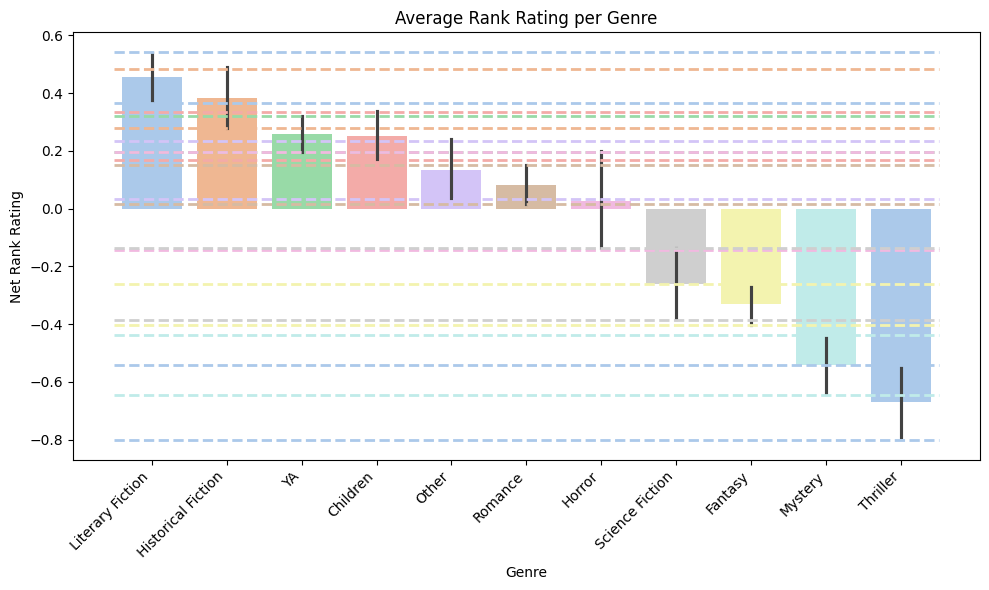

In [92]:
# Genre ME - Neg - Plot

# Calculate means and confidence intervals per group
summary = df_filtered.groupby('master_genre')['net_lower_rank'].agg(['mean', 'count', 'std']).reset_index()
summary['sem'] = summary['std'] / summary['count']**0.5
summary['ci95'] = summary['sem'] * stats.t.ppf(0.975, df=summary['count']-1)  # 95% CI

# Sort genres by mean for consistent ordering
summary = summary.sort_values('mean', ascending=False)
order = summary['master_genre']

plt.figure(figsize=(10, 6))

# Plot bars with seaborn, ordered by 'order'
barplot = sns.barplot(data=df_filtered, 
                      x='master_genre', 
                      y='net_lower_rank', 
                      order=order, 
                      palette='pastel', 
                      errorbar=('ci', 95))

# Map bar colors to genres
bar_colors = {}
for patch in barplot.patches:
    # x coordinate is the bar index
    x_pos = int(patch.get_x() + patch.get_width() / 2 + 0.001)  # tiny offset to avoid float issues
    bar_colors[order.iloc[x_pos]] = patch.get_facecolor()

# Draw horizontal mean lines and two dashed lines for CI bounds
for _, row in summary.iterrows():
    genre = row['master_genre']
    mean = row['mean']
    ci = row['ci95']
    color = bar_colors[genre]
    
    # Lower CI bound dashed line
    plt.hlines(y=mean - ci, xmin=-0.5, xmax=len(summary)-0.5, colors=color, linestyles='dashed', linewidth=2)
    
    # Upper CI bound dashed line
    plt.hlines(y=mean + ci, xmin=-0.5, xmax=len(summary)-0.5, colors=color, linestyles='dashed', linewidth=2)

plt.title("Average Rank Rating per Genre")
plt.xticks(ticks=range(len(summary)), labels=order, rotation=45, ha='right')
plt.ylabel("Net Rank Rating")
plt.xlabel("Genre")
plt.tight_layout()
plt.show()

Rank 
literary fiction, historical fiction
fantasy, mystery, thriller 

In [93]:
# ONLINE SUPPLEMENT ONLY
# Genre ME - Significance Test 

# Drop NA values to avoid errors
df_clean = df_filtered[['master_genre', 'net_lower_rank']].dropna()

# Perform Tukey HSD
tukey = pairwise_tukeyhsd(endog=df_clean['net_lower_rank'],
                          groups=df_clean['master_genre'],
                          alpha=0.05)

print(tukey.summary())

# Convert Tukey results to a DataFrame
tukey_results = pd.DataFrame(
    data=tukey._results_table.data[1:],  # Skip header
    columns=tukey._results_table.data[0]  # Column names
)
tukey_results.to_latex('tukey_results.tex', index=False)

            Multiple Comparison of Means - Tukey HSD, FWER=0.05             
      group1             group2       meandiff p-adj   lower   upper  reject
----------------------------------------------------------------------------
          Children            Fantasy  -0.5827    0.0 -0.9002 -0.2652   True
          Children Historical Fiction   0.1315 0.9711 -0.1974  0.4605  False
          Children             Horror  -0.2245 0.8437 -0.6535  0.2045  False
          Children   Literary Fiction    0.204 0.6385 -0.1219  0.5299  False
          Children            Mystery   -0.793    0.0 -1.1289  -0.457   True
          Children              Other  -0.1176   0.99 -0.4571  0.2218  False
          Children            Romance  -0.1679 0.8126  -0.478  0.1421  False
          Children    Science Fiction   -0.513 0.0002  -0.873  -0.153   True
          Children           Thriller  -0.9227    0.0 -1.2782 -0.5673   True
          Children                 YA   0.0071    1.0 -0.3298   0.344  False

##### Appearance Focus Pos Only

In [94]:
# ANOVA for easier reporting of categorical predictor results
# Effect Sizes
anova = pg.anova(
    data=df_filtered,
    dv='z_appearance_pos',
    between=['author_gender', 'master_genre'],
    detailed=True
)

print(anova)

# Effect size author gender: 0.026562  
# Effect size genre: 0.043701
# Effect size author gender*genre: 0.005916

                         Source           SS       DF          MS           F  \
0                 author_gender   259.484828      1.0  259.484828  276.828690   
1                  master_genre   434.560710     10.0   43.456071   46.360657   
2  author_gender * master_genre    56.594880     10.0    5.659488    6.037766   
3                      Residual  9509.395799  10145.0    0.937348         NaN   

          p-unc       np2  
0  2.388142e-61  0.026562  
1  3.737707e-91  0.043701  
2  3.289472e-09  0.005916  
3           NaN       NaN  


df_filtered['z_appearance_pos']

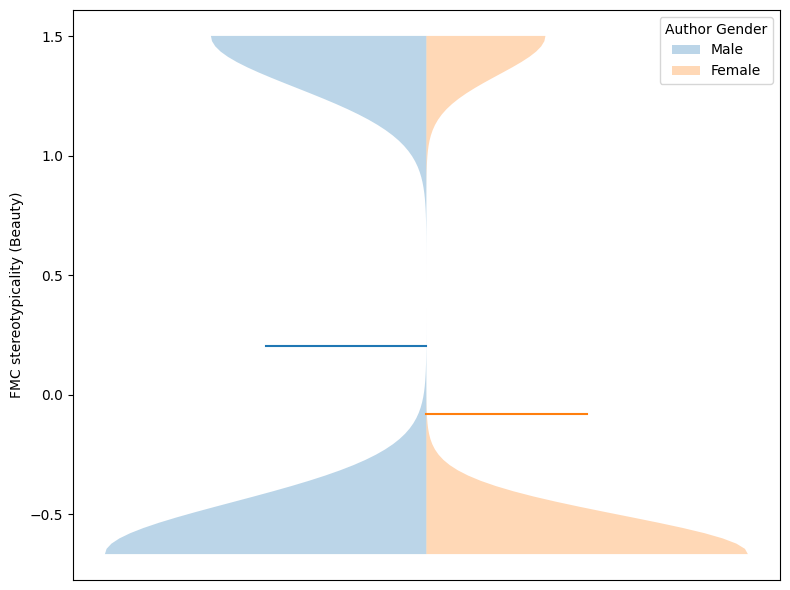

In [137]:
# Extract groups
male_data = df_filtered[df_filtered['author_gender'] == 'Male']['z_appearance_pos']
female_data = df_filtered[df_filtered['author_gender'] == 'Female']['z_appearance_pos']

fig, ax = plt.subplots(figsize=(8, 6))

v1 = ax.violinplot(
    male_data,
    positions=[0],
    showmeans=True,
    showmedians=False,
    showextrema=False,
    side='low'
)

v2 = ax.violinplot(
    female_data,
    positions=[0],
    showmeans=True,
    showmedians=False,
    showextrema=False,
    side='high'
)

# Axis labels
ax.set_xticks([]) 
ax.set_xticklabels([])
ax.set_ylabel("FMC stereotypicality (Beauty)")

from matplotlib.patches import Patch

# Get actual colors from the violin objects
male_color = v1['bodies'][0].get_facecolor().flatten()
female_color = v2['bodies'][0].get_facecolor().flatten()

legend_elements = [
    Patch(facecolor=male_color, label='Male'),
    Patch(facecolor=female_color, label='Female')
]

ax.legend(handles=legend_elements, title='Author Gender')

plt.tight_layout()
plt.show()

In [138]:
# Author Gender - Effect size

# Subset the groups
group_female_agency = df_filtered[df_filtered['author_gender'] == "Female"]['z_appearance_pos']
group_male_agency = df_filtered[df_filtered['author_gender'] == "Male"]['z_appearance_pos']

# Calculate Cohen's d
d = pg.compute_effsize(group_female_agency, group_male_agency, eftype='cohen', paired=False)

print("Cohen's d:", d)

Cohen's d: -0.2863510949201364


In [139]:
# ONLINE SUPPLEMENT ONLY
# Gender ME - Significance Test 

# Drop NA values to avoid errors
df_clean = df_filtered[['author_gender', 'z_appearance_pos']].dropna()

# Perform Tukey HSD
tukey = pairwise_tukeyhsd(endog=df_clean['z_appearance_pos'],
                          groups=df_clean['author_gender'],
                          alpha=0.05)

print(tukey.summary())

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj lower  upper  reject
-------------------------------------------------
Female   Male    0.284   0.0 0.2412 0.3268   True
-------------------------------------------------


/var/folders/g_/q_msxx211pb8_18_mgg8djyr0000gn/T/ipykernel_2917/2392344693.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(data=df_filtered,


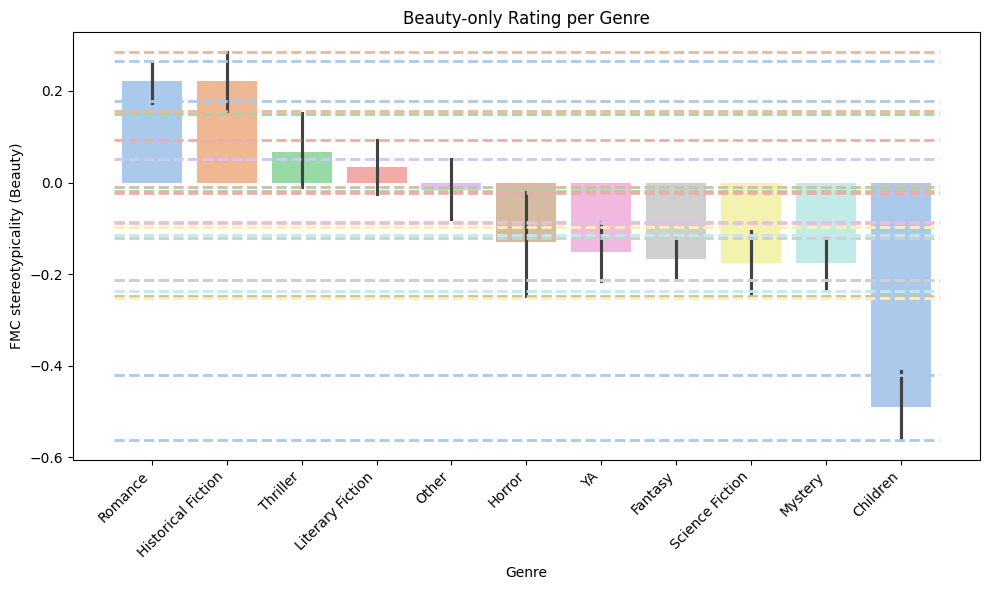

In [141]:
# Genre ME - Appearance pos - Plot

# Calculate means and confidence intervals per group
summary = df_filtered.groupby('master_genre')['z_appearance_pos'].agg(['mean', 'count', 'std']).reset_index()
summary['sem'] = summary['std'] / summary['count']**0.5
summary['ci95'] = summary['sem'] * stats.t.ppf(0.975, df=summary['count']-1)  # 95% CI

# Sort genres by mean for consistent ordering
summary = summary.sort_values('mean', ascending=False)
order = summary['master_genre']

plt.figure(figsize=(10, 6))

# Plot bars with seaborn, ordered by 'order'
barplot = sns.barplot(data=df_filtered, 
                      x='master_genre', 
                      y='z_appearance_pos', 
                      order=order, 
                      palette='pastel', 
                      errorbar=('ci', 95))

# Map bar colors to genres
bar_colors = {}
for patch in barplot.patches:
    # x coordinate is the bar index
    x_pos = int(patch.get_x() + patch.get_width() / 2 + 0.001)  # tiny offset to avoid float issues
    bar_colors[order.iloc[x_pos]] = patch.get_facecolor()

# Draw horizontal mean lines and two dashed lines for CI bounds
for _, row in summary.iterrows():
    genre = row['master_genre']
    mean = row['mean']
    ci = row['ci95']
    color = bar_colors[genre]
    
    # Lower CI bound dashed line
    plt.hlines(y=mean - ci, xmin=-0.5, xmax=len(summary)-0.5, colors=color, linestyles='dashed', linewidth=2)
    
    # Upper CI bound dashed line
    plt.hlines(y=mean + ci, xmin=-0.5, xmax=len(summary)-0.5, colors=color, linestyles='dashed', linewidth=2)

plt.title("Beauty-only Rating per Genre")
plt.xticks(ticks=range(len(summary)), labels=order, rotation=45, ha='right')
plt.ylabel("FMC stereotypicality (Beauty)")
plt.xlabel("Genre")
plt.tight_layout()
plt.show()

In [98]:
# ONLINE SUPPLEMENT ONLY
# Genre ME - Significance Test 

# Drop NA values to avoid errors
df_clean = df_filtered[['master_genre', 'z_appearance_pos']].dropna()

# Perform Tukey HSD
tukey = pairwise_tukeyhsd(endog=df_clean['z_appearance_pos'],
                          groups=df_clean['master_genre'],
                          alpha=0.05)

print(tukey.summary())

            Multiple Comparison of Means - Tukey HSD, FWER=0.05             
      group1             group2       meandiff p-adj   lower   upper  reject
----------------------------------------------------------------------------
          Children            Fantasy    0.324    0.0   0.116   0.532   True
          Children Historical Fiction   0.7115    0.0   0.496   0.927   True
          Children             Horror    0.362 0.0017  0.0809   0.643   True
          Children   Literary Fiction   0.5257    0.0  0.3122  0.7393   True
          Children            Mystery   0.3158 0.0002  0.0957  0.5359   True
          Children              Other   0.4735    0.0  0.2511   0.696   True
          Children            Romance   0.7116    0.0  0.5085  0.9147   True
          Children    Science Fiction   0.3158 0.0008  0.0799  0.5517   True
          Children           Thriller   0.5572    0.0  0.3243  0.7901   True
          Children                 YA   0.3396    0.0  0.1189  0.5603   True

/var/folders/g_/q_msxx211pb8_18_mgg8djyr0000gn/T/ipykernel_2917/505717237.py:41: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = genre_data.groupby('author_gender')['z_appearance_pos'].mean()


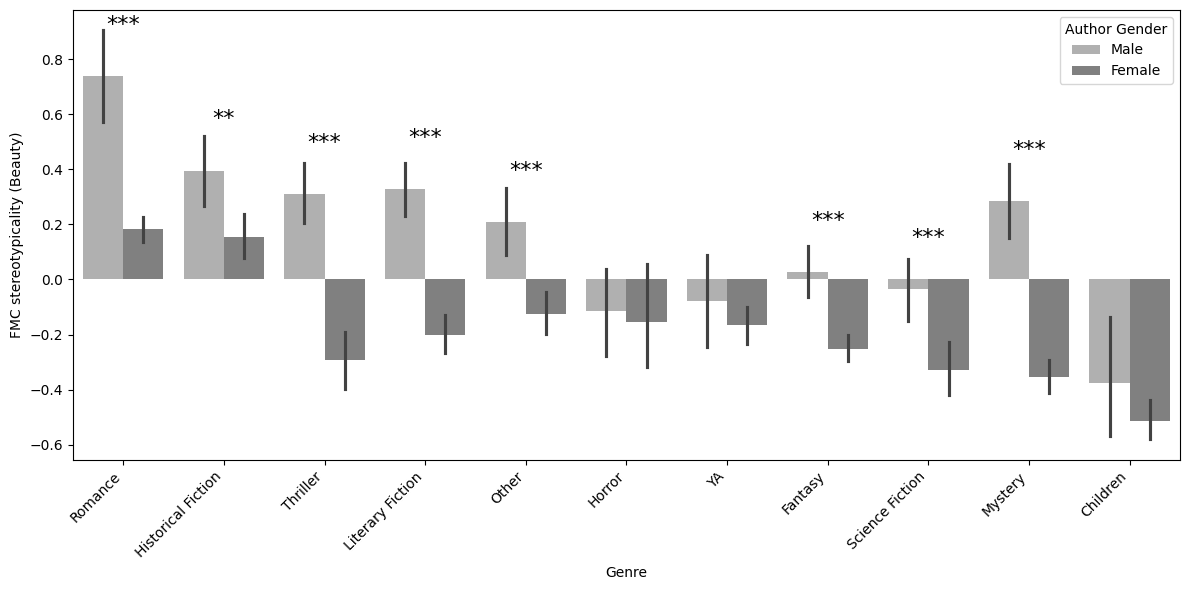

In [ ]:
# order genres by their mean z_appearance_pos
means_by_genre = df_filtered.groupby('master_genre')['z_appearance_pos'].mean().sort_values(ascending=False)
genre_order = means_by_genre.index

plt.figure(figsize=(12, 6))

ax = sns.barplot(
    data=df_filtered,
    x='master_genre',
    y='z_appearance_pos',
    hue='author_gender',
    palette=gray_colors,
    errorbar=('ci', 95),
    order=genre_order
)

plt.xticks(rotation=45, ha='right')
plt.ylabel("FMC stereotypicality (Beauty)")
plt.xlabel("Genre")
plt.legend(title="Author Gender")
plt.tight_layout()

# Add significance stars for gender difference within each genre
for i, genre in enumerate(genre_order):
    genre_data = df_filtered[df_filtered['master_genre'] == genre]
    tukey = pairwise_tukeyhsd(endog=genre_data['z_appearance_pos'],
                              groups=genre_data['author_gender'],
                              alpha=0.05)
    try:
        pval = tukey.pvalues[0]
    except Exception:
        pval = np.nan
    if pval < 0.001:
        stars = '***'
    elif pval < 0.01:
        stars = '**'
    elif pval < 0.05:
        stars = '*'
    else:
        stars = ''
    means = genre_data.groupby('author_gender')['z_appearance_pos'].mean()
    y_max = means.max()
    ax.text(i, y_max + 0.15, stars, ha='center', va='bottom', fontsize=16, color='black')

plt.savefig("../visualizations/Figure 7 old.png", dpi=300)
plt.show()

In [100]:
# ONLINE SUPPLEMENT ONLY
# Interaction - Comp/agencey  - Significance Test

df_clean = df_filtered[['master_genre', 'author_gender', 'z_appearance_pos']].dropna()

# Create interaction column
df_clean['interaction'] = df_clean['author_gender'].astype(str) + "_" + df_clean['master_genre'].astype(str)

# Run Tukey's HSD
tukey = pairwise_tukeyhsd(endog=df_clean['z_appearance_pos'],
                          groups=df_clean['interaction'],
                          alpha=0.05)

print(tukey.summary())

/Users/hannes/Documents/svenjas paper/.venv/lib/python3.13/site-packages/scipy/integrate/_quadpack_py.py:1264: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


                   Multiple Comparison of Means - Tukey HSD, FWER=0.05                    
          group1                    group2          meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------------------------
          Female_Children            Female_Fantasy   0.2624 0.0331  0.0086  0.5163   True
          Female_Children Female_Historical Fiction   0.6671    0.0  0.4038  0.9305   True
          Female_Children             Female_Horror   0.3599 0.2515 -0.0685  0.7883  False
          Female_Children   Female_Literary Fiction   0.3121 0.0059   0.043  0.5813   True
          Female_Children            Female_Mystery   0.1579 0.8885  -0.112  0.4277  False
          Female_Children              Female_Other   0.3881 0.0001  0.1126  0.6635   True
          Female_Children            Female_Romance   0.6962    0.0  0.4532  0.9392   True
          Female_Children    Female_Science Fiction   0.1859 0.8867 -0.1313  0.5031  False